# Imports et setup technique

In [1]:
import pandas as pd
from IPython.display import display
idx = pd.IndexSlice
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
mcolorpalette = list(mcolor.TABLEAU_COLORS.values())
import matplotlib.dates as mdates
from pathlib import Path
persist_path = Path('..') / 'persist'
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
from bokeh.io import output_notebook, show
output_notebook()
from bokeh.plotting import figure
from bokeh.models import CDSView, ColumnDataSource, GroupFilter, FactorRange, HoverTool
from bokeh.models.annotations import BoxAnnotation
from bokeh.layouts import row, column
from bokeh.models.formatters import NumeralTickFormatter

from functools import partial
from datetime import datetime, date
import sys
project_root = str(Path(sys.path[0]).parents[0].absolute())
if project_root not in sys.path:
    sys.path.append(project_root)
from importlib import reload
from scripts.utils import compute_zscores, process_df, compute_distribution
import scripts.utils as utils

Loading BokehJS ...

# Intégration des fichiers

## Données de base client

In [2]:
cltfields = {
             'client': 'object',
             'V': 'object',
             'groupecompte': 'object',
             'nom': 'object',
             'postalcode': 'object',
             'seg1': 'object',
             'seg2': 'object',
             'seg3': 'object',
             'seg4': 'object',
             'cat': 'object',
             'sscat': 'object',
#              'saiso': 'bool',
             'surcat': 'object',
#              'ecom': 'bool', 
             'sectact': 'object',
             'canal': 'object', 
             'orgacom': 'object', 
             'grpclt1': 'object',
             'grpclt2': 'object',
             'grpclt3': 'object',
             'grpclt4': 'object',
             'grpclt5': 'object',
             'agence': 'object', 
             'condexp': 'object', 
             'pricetype': 'object', 
             'relationtype': 'object',
             'pilcom': 'object',
             'hier4': 'object',
             'hier3': 'object',
             'hier2': 'object',
             'hier1': 'object',
            }

clt_fields2 = {
             'client': 'object',
             'V': 'category',
             'groupecompte': 'category',
             'nom': 'object',
             'postalcode': 'category',
             'seg1': 'category',
             'seg2': 'category',
             'seg3': 'category',
             'seg4': 'category',
             'cat': 'category',
             'sscat': 'category',
#              'saiso': 'bool',
             'surcat': 'category',
#              'ecom': 'bool', 
             'sectact': 'category',
             'canal': 'category', 
             'orgacom': 'category', 
             'grpclt1': 'category',
             'grpclt2': 'category',
             'grpclt3': 'category',
             'grpclt4': 'category',
             'grpclt5': 'category',
             'agence': 'category', 
             'condexp': 'category', 
             'pricetype': 'category', 
             'relationtype': 'category',
             'pilcom': 'category',
             'hier4': 'object',
             'hier3': 'object',
             'hier2': 'object',
             'hier1': 'object',
            }

filenames = [
    'ref_clt.csv',
    'ref_clt2.csv',
    'export2BRE_clt.csv',
    'exportcomp1ALO.csv',
]
paths = [Path('..') / 'data' / 'clt' / 'small' / filename for filename in filenames]

df_clts = [
    pd.read_csv(path,
                sep=';',
                encoding='latin1', 
                dtype=cltfields,
                converters={'saiso': lambda x: True if x == 'YES' else False, 
                            'ecom': lambda x: True if x == 'X' else False},
                ) for path in paths
]

df_clt = pd.concat(df_clts, axis=0)
for field, dtype in clt_fields2.items(): 
    if field not in df_clt.columns:
        print(field)
df_clt = df_clt.astype(clt_fields2)
df_clt.sample(5)

client  V groupecompte                    nom postalcode seg1 seg2  \
50847  CR00178956  A         ZCRI                 L AYGO      64320  NaN  NaN   
31581      183943  A         ZHIE           France FRAIS      21200  NaN  NaN   
2568        24002  A         ZCLT        TRAITEUR DOLLEZ      57525   Z3   Z5   
14388      178175  A         ZCRC    PEP'S NANTES ZENITH      44800   Z3   Z5   
9772       114756  A         ZHIE  KELLY DELI FRANCHISES      75011  NaN  NaN   

      seg3 seg4  cat  ... grpclt5  agence condexp  pricetype relationtype  \
50847  NaN  NaN  NaN  ...     NaN     NaN     NaN        NaN          NaN   
31581  NaN  NaN  NaN  ...     NaN     NaN     NaN        NaN          NaN   
2568    ZK   ZG   ZY  ...     NaN    1MET     NaN        NaN          NaN   
14388   ZK   ZG   ZW  ...     051    2LOI      ST         T3          NDI   
9772   NaN  NaN  NaN  ...     NaN     NaN     NaN        NaN          NaN   

      pilcom hier4 hier3 hier2 hier1  
50847    NaN   NaN   NaN   NaN   NaN  
31581    NaN   NaN   NaN   NaN   NaN  
2568     NaN   NaN   NaN   NaN   NaN  
14388    RGL   NaN   NaN   NaN   NaN  
9772     NaN   NaN   NaN   NaN   NaN  

[5 rows x 31 columns]

In [3]:
# remove emppty client codes
df_clt = df_clt.loc[~df_clt.client.isna()]

# zero pad numeric clients codes
num_clt_mask = df_clt['client'].str.isnumeric()
df_clt.loc[num_clt_mask, 'client'] = df_clt.loc[num_clt_mask, 'client'].str.zfill(10)

#remove duplicated clients
print(f'Clients count before cleansing : {df_clt.client.count()}')
print(f"Duplicated clients before cleansing: {sum(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False))}")
df_clt = df_clt.loc[~(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False) & df_clt.sectact.isna())]
print(f"Clients count after cleansing : {df_clt.client.count()}")
print(f"Duplicated clients after cleansing: {sum(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False))}")

# set the index
df_clt.set_index(['orgacom', 'client'], inplace=True, drop=True)

Clients count before cleansing : 104640
Duplicated clients before cleansing: 4634
Clients count after cleansing : 102323
Duplicated clients after cleansing: 0


In [4]:
df_clt.sample(5)

V groupecompte                             nom postalcode  \
orgacom client                                                                  
1SOU    0000193478  A         ZCLT      INSTANT TRAITEUR PERIGUEUX      24750   
        0000145341  A         ZCLT              TUTTI PIZZA TARBES      65000   
1ALO    0000064697  A         ZCLT       REST LA CIGOGNE GOURMANDE      67500   
2BRE    0000082444  A         ZCRC                ECOL DE LANMODEZ      22610   
1ALO    0000025182  A         ZCLT  CGF MDR BEL AUTOMNE DRUSENHEIM      67410   

                   seg1 seg2 seg3 seg4 cat sscat  ...  grpclt5 agence  \
orgacom client                                    ...                   
1SOU    0000193478   Z3   Z5   ZL   ZH  ZV   Z22  ...      051   1BDX   
        0000145341   Z3   Z5   ZL   ZH  ZU    ZN  ...      051   1PAU   
1ALO    0000064697   Z3   Z5   ZK   ZG  ZS    ZK  ...      051   1STR   
2BRE    0000082444   Z3   Z4   ZI   ZB  ZL   Z12  ...      051   2COT   
1ALO    0000025182   Z3   Z4   ZJ   ZF  ZN   Z19  ...      051   1STR   

                    condexp pricetype relationtype pilcom   hier4   hier3  \
orgacom client                                                              
1SOU    0000193478       ST       NaN          DIR    RGL  148742  148743   
        0000145341       ST       NaN          DIR    RGL   55552   55553   
1ALO    0000064697       ST        T1          NDI    RGL   11150   11151   
2BRE    0000082444       ST        T1          NDI    RGL     NaN     NaN   
1ALO    0000025182       ST       NaN          DIR    BIG   10337   10339   

                     hier2   hier1  
orgacom client                      
1SOU    0000193478  148744  148775  
        0000145341   55554   55565  
1ALO    0000064697   11154   11158  
2BRE    0000082444     NaN     NaN  
1ALO    0000025182   10343   10357  

[5 rows x 29 columns]

In [5]:
if sum(df_clt.index.duplicated()):
    raise RuntimeError('Something went wrong on the client dataframe! Some indices are duplicated!')

In [6]:
print(*df_clt.groupecompte.unique())

ZCLT ZFAC ZCHN ZCFR ZPER ZLIV ZCRC ZHIE ZCOL ZREG ZCTR ZCFE ZCAC ZCFG ZCPP ZCRI ZCRM ZGPE 0100 ZCPD ZCAB


Libellés des segments clients :

In [7]:
path = Path('..') / 'data' / 'libelles_segments.csv'
lib_seg = pd.read_csv(path,
                      sep=';',
                      encoding='latin1',
                      header=None,
                      names=['level', 'code', 'designation'],
                      index_col=['level', 'code']
                     )
lib_seg

designation
level code                      
1     Z1            Distribution
      Z3                     RHD
      Z4                  Divers
2     Z0       Autres clientèles
      Z1                     GMS
...                          ...
6     ZV          Gare/ Aéroport
      ZW     Rest. sur autoroute
      ZX    Station service btiq
      ZY      Traiteur Réception
      ZZ       Traiteur Boutique

[149 rows x 1 columns]

In [8]:
df_clt.to_pickle(persist_path / 'small_clt.pkl')
lib_seg.to_pickle(persist_path / 'small_lib_seg.pkl')

## Historiques de vente

In [9]:
# path = Path('..') / 'data' / 'EXTRACT_LIGNES_VENTES.csv'
# path = Path('..') / 'data' / 'EXTRACT_LIGNES_VENTES_v2.csv'
path_list = [
    Path('..') / 'data' / 'small' / filename 
    for filename in [
        'EXTRACT_LIGNES_VENTES_V3.csv',
        'EXTRACTION_2BRE.csv'
    ]
]
fields = {'orgacom': pd.CategoricalDtype(['1SOU', '1ALO', '1LRO', '2BRE'], ordered=True),
          'month': 'category',
          'week': 'category',
          'date': 'object',
          'pricetype': 'category',
          'client': 'object',
          'doctype': 'category',
          'origin': pd.CategoricalDtype(['TV', 'VR', 'EDI', 'WEB', '#', 'SCHR', 'TELE',
                                         'MUEN', 'FRN', 'DFUE'], ordered=True),
          'salesgroup': 'category',
          'material': 'object',
          'brutrevenue': 'float',
          'brutrevcur': 'category', 
          'netrevenue': 'float', 
          'netrevcur': 'category',
          'weight': 'float',
          'weightunit': 'category',
          'margin': 'float', 
          'margincur': 'category', 
          'marginperkg': 'float',
         }

In [10]:
%%time
data = [pd.read_csv(path,
                   sep=';',
                   header=None,
                   names=list(fields.keys()),      
                   dtype=fields, 
                   parse_dates=['date'],
                  ) for path in path_list]
data = pd.concat(data, axis=0)
data.sample(5)

CPU times: user 1min 17s, sys: 14.8 s, total: 1min 31s
Wall time: 1min 31s


orgacom   month    week       date pricetype      client doctype  \
20875423    1SOU  201906  201924 2019-06-13      ZTCN  0000069930    ZC10   
25555643    1SOU  201911  201946 2019-11-17      ZTCE  0000070625    ZC10   
22830072    1SOU  201908  201933 2019-08-13      ZTCR  0000069081    ZC10   
6419319     1SOU  201802  201806 2018-02-06       ZTG  0000202026    ZC10   
16429226    1ALO  201901  201904 2019-01-22       ZTP  0000198302    ZC10   

         origin salesgroup            material  brutrevenue brutrevcur  \
20875423    EDI        819  000000000000031921        13.49        EUR   
25555643    EDI        801  000000000000096480         0.00        EUR   
22830072     TV        791  000000000000060185        20.00        EUR   
6419319      VR        K99  000000000000052632        36.17        EUR   
16429226     TV        641  000000000000083584        37.95        EUR   

          netrevenue netrevcur  weight weightunit  margin margincur  \
20875423       11.07       EUR  10.000         KG    1.14       EUR   
25555643       -0.16       EUR   0.000         KG   -0.16       EUR   
22830072       20.00       EUR   5.000         KG   11.59       EUR   
6419319        36.17       EUR   3.318         KG    9.47       EUR   
16429226       37.95       EUR   5.460         KG    6.38       EUR   

          marginperkg  
20875423         0.11  
25555643         0.00  
22830072         2.32  
6419319          2.85  
16429226         1.17

In [11]:
print(f"Nombre de lignes d'historique de vente : {len(data)}")

Nombre de lignes d'historique de vente : 39793822


# Contrôles basiques
## Types de documents
Contrôle des types de poste extraits.

In [12]:
valid_doctypes = ['ZC01', 'ZC02', 'ZC10']
invalid_doctypes = ['ZR01', 'ZR02', 'ZA01', 'ZA02', 'ZA03', 'ZA04', 'ZC20']
doctypes = valid_doctypes + invalid_doctypes

In [13]:
if len(data.loc[~data.doctype.isin(doctypes)]) > 0:
    raise RuntimeError(f'An unexpected doctype has been encountered: '
                       f'{data.loc[~data.doctype.isin(doctypes), "doctype"].iloc[0]}!')

In [14]:
order_doctype_mask = data.doctype.isin(valid_doctypes)

## Contrôle des ventes avec du CA mais pas de poids associé
On contrôle d'abord qu'il n'y a pas de ligne de commande avec un poids à zéro mais un CA associé

In [15]:
if len(data.loc[order_doctype_mask & (data.weight == 0) & (data.brutrevenue != 0)]) > 0:
    print('Some sales have no weight but have brut revenue!')
data.loc[order_doctype_mask & (data.weight == 0) & (data.brutrevenue != 0), 'material'].unique()

Some sales have no weight but have brut revenue!


array(['FL ACCOR', 'FL39860', 'FL66446', 'FC42378', '000000000000156486',
       'FC34504', 'FC34502', 'FC34503'], dtype=object)

On contrôle que le CA brut des commandes est toujours positif.

In [16]:
if len(data.loc[order_doctype_mask & (data.brutrevenue < 0)]) > 0: 
    raise RuntimeError('Some sales have negative brut revenue!')

# Nettoyage des avoirs
## Constat d'erreurs
Il apparaît que certaines erreurs sur les prix qui faussent l'analyse ont eu un impact fort sur les indicateurs :

# Calcul des indicateurs composites (PMVK, marge €/kg...)

In [17]:
# data['purchcost'] = data.brutrevenue - data.margin
# data['purchcostperkg'] = data.purchcost / data.weight
# data['PMVK'] = data.brutrevenue / data.weight
# data['marginpercent'] = (data.margin / data.brutrevenue).replace({np.inf: np.nan, -np.inf: np.nan})

# Nettoyage des avoirs
## Constat d'erreurs et corrections sur les prix¶
Il apparaît que certaines erreurs sur les prix qui faussent l'analyse ont eu un impact fort sur les indicateurs :

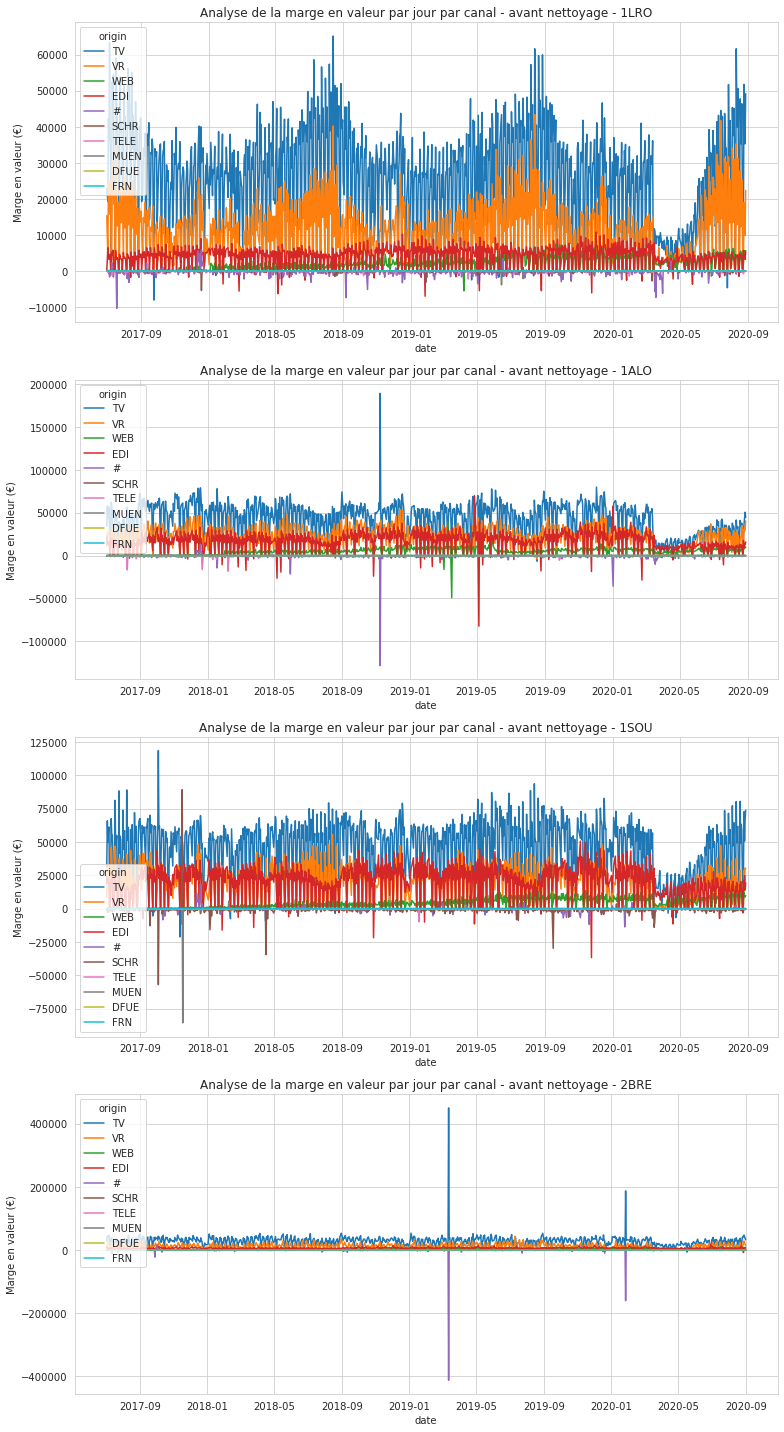

In [19]:
mult_origins_order = ['TV', 'VR', 'WEB', 'EDI', '#', 'SCHR', 'TELE', 'MUEN', 'DFUE', 'FRN']

nrows = len(data.orgacom.unique())
fig, axs = plt.subplots(figsize = (11, 5 * nrows), nrows=nrows)
orgacoms = data.orgacom.unique().tolist()
data_to_plot = [(
    data.loc[data.orgacom == orgacom]
        .groupby(['date', 'origin'])['margin']
        .sum()
        .unstack('origin')
        .rolling(1, win_type='triang')
        .mean()
        .stack('origin')
        .rename('margin')
        .reset_index()
) for orgacom in orgacoms]

for i, data_ in enumerate(data_to_plot):
    sns.lineplot(data=data_,
                 x='date',
                 y='margin',
                 hue='origin',
                 hue_order=mult_origins_order,
                 ax=axs[i])
    axs[i].set_title(f'Analyse de la marge en valeur par jour par canal - avant nettoyage - {orgacoms[i]}')
    axs[i].set_ylabel('Marge en valeur (€)')
fig.tight_layout()

On voit 3 gros pics négatifs qui sont des corrections d'erreur sur les prix, mais pas affectés au canal correspondant.

## Retraitement des avoirs

In [20]:
myfields = ['orgacom',
            'doctype',
            'date',
            'origin',
            'material',
            'client',
            'brutrevenue',
            'weight',
            'PMVK',
            'marginperkg',
            'margin',
            'purchcost',
            'purchcostperkg']

In [21]:
len_before = len(data.loc[data.doctype.isin(['ZA01', 'ZA02'])])
brutrev_before = data.loc[data.doctype.isin(['ZA01', 'ZA02']), 'brutrevenue'].sum()

In [22]:
print('Avant nettoyage')
print(f"Nombre d'avoirs ZA01 et ZA02 : {len_before}")
print(f"CA représenté par ces avoirs : {brutrev_before: .2f} €")

Avant nettoyage
Nombre d'avoirs ZA01 et ZA02 : 136817
CA représenté par ces avoirs : -4880871.31 €


In [25]:
%%time
dfs = []
for suc in data.orgacom.unique():
    print(f'Début du traitement pour {suc}')
    to_process = data.loc[data.orgacom == suc]
    data = data.loc[data.orgacom != suc]
    dfs.append(process_df(to_process))

Début du traitement pour 1LRO
Evolution des indicateurs pendant le traitement : 
margin         7.450581e-08
brutrevenue    2.980232e-07
weight         0.000000e+00
dtype: float64
Début du traitement pour 1ALO
Evolution des indicateurs pendant le traitement : 
margin        -1.490116e-08
brutrevenue    2.980232e-07
weight        -1.192093e-07
dtype: float64
Début du traitement pour 1SOU
Evolution des indicateurs pendant le traitement : 
margin        -2.980232e-08
brutrevenue    0.000000e+00
weight         1.639128e-07
dtype: float64
Début du traitement pour 2BRE
Evolution des indicateurs pendant le traitement : 
margin        -4.470348e-08
brutrevenue    1.192093e-07
weight        -2.831221e-07
dtype: float64
CPU times: user 5min, sys: 1min 40s, total: 6min 41s
Wall time: 6min 41s


In [26]:
data = pd.concat(dfs, axis=0)
del(dfs)
data.head(10)

orgacom   month    week       date pricetype      client doctype  \
2809606    1ALO  201803  201810 2018-03-07      ZTCE  0000103063    ZC10   
829914     1ALO  201709  201738 2017-09-20      ZTCE  0000027871    ZC10   
239424     1SOU  201707  201729 2017-07-21      ZTCE  0000125102    ZC10   
1473631    1ALO  201711  201746 2017-11-13      ZTCE  0000027387    ZC10   
8988582    1ALO  201908  201935 2019-08-30       ZTG  0000020530    ZC10   
6036823    1ALO  201812  201850 2018-12-11       ZTP  0000028700    ZC10   
2795134    1SOU  201802  201808 2018-02-23      ZTCE  0000131453    ZC10   
432247     1LRO  201709  201735 2017-09-01      ZTCR  0000197110    ZC10   
63295      1ALO  201707  201727 2017-07-07      ZTCE  0000150305    ZC10   
8467325    1SOU  201906  201923 2019-06-04      ZTCR  0000067324    ZC10   

        origin salesgroup            material  ...  netrevcur  weight  \
2809606    EDI        647  000000000000087900  ...        EUR  10.000   
829914      TV        614  000000000000020090  ...        EUR   2.000   
239424     EDI        801  000000000000007152  ...        EUR  10.000   
1473631    EDI        589  000000000000091413  ...        EUR   2.500   
8988582     TV        H14  000000000000049373  ...        EUR  12.000   
6036823     TV        H16  000000000000189466  ...        EUR   6.720   
2795134     TV        782  000000000000053893  ...        EUR   7.000   
432247      TV        744  000000000000032726  ...        EUR   2.000   
63295       TV        H28  000000000000019388  ...        EUR   1.333   
8467325     VR        787  000000000000032510  ...        EUR  25.000   

         weightunit margin  margincur marginperkg  purchcost purchcostperkg  \
2809606          KG   2.71        EUR        0.27      13.28       1.328000   
829914           KG   0.99        EUR        0.50       4.11       2.055000   
239424           KG   0.49        EUR        0.05      11.09       1.109000   
1473631          KG   0.73        EUR        0.29       1.97       0.788000   
8988582          KG  87.90        EUR        7.33      31.43       2.619167   
6036823          KG  23.34        EUR        3.47      25.72       3.827381   
2795134          KG   3.26        EUR        0.47      13.88       1.982857   
432247           KG   7.24        EUR        3.62      12.16       6.080000   
63295            KG   0.92        EUR        0.69      10.03       7.524381   
8467325          KG  80.24        EUR        3.21     232.26       9.290400   

              PMVK  marginpercent  
2809606   1.599000       0.169481  
829914    2.550000       0.194118  
239424    1.158000       0.042314  
1473631   1.080000       0.270370  
8988582   9.944167       0.736613  
6036823   7.300595       0.475744  
2795134   2.448571       0.190198  
432247    9.700000       0.373196  
63295     8.214554       0.084018  
8467325  12.500000       0.256768  

[10 rows x 23 columns]

In [27]:
len_after = len(data.loc[data.doctype.isin(['ZA01', 'ZA02'])])
brutrev_after = data.loc[data.doctype.isin(['ZA01', 'ZA02']), 'brutrevenue'].sum()

In [28]:
print('Après nettoyage')
print(f"Nombre d'avoirs ZA01 et ZA02 : {len_after}. "
      f"Evolution : {len_before - len_after} lignes retraitées "
      f"soit : {(len_before - len_after)/len_before:.2%}")
print(f"CA représenté par ces avoirs : {brutrev_after: .2f} €. "
      f"Evolution : {brutrev_after - brutrev_before:.2f} € retraités "
      f"soit : {(brutrev_before - brutrev_after)/brutrev_before:.2%}")

Après nettoyage
Nombre d'avoirs ZA01 et ZA02 : 119841. Evolution : 16976 lignes retraitées soit : 12.41%
CA représenté par ces avoirs : -3229336.34 €. Evolution : 1651534.97 € retraités soit : 33.84%


## Vérification de l'impact de la correction

On peut plotter les indicateurs après nettoyage :

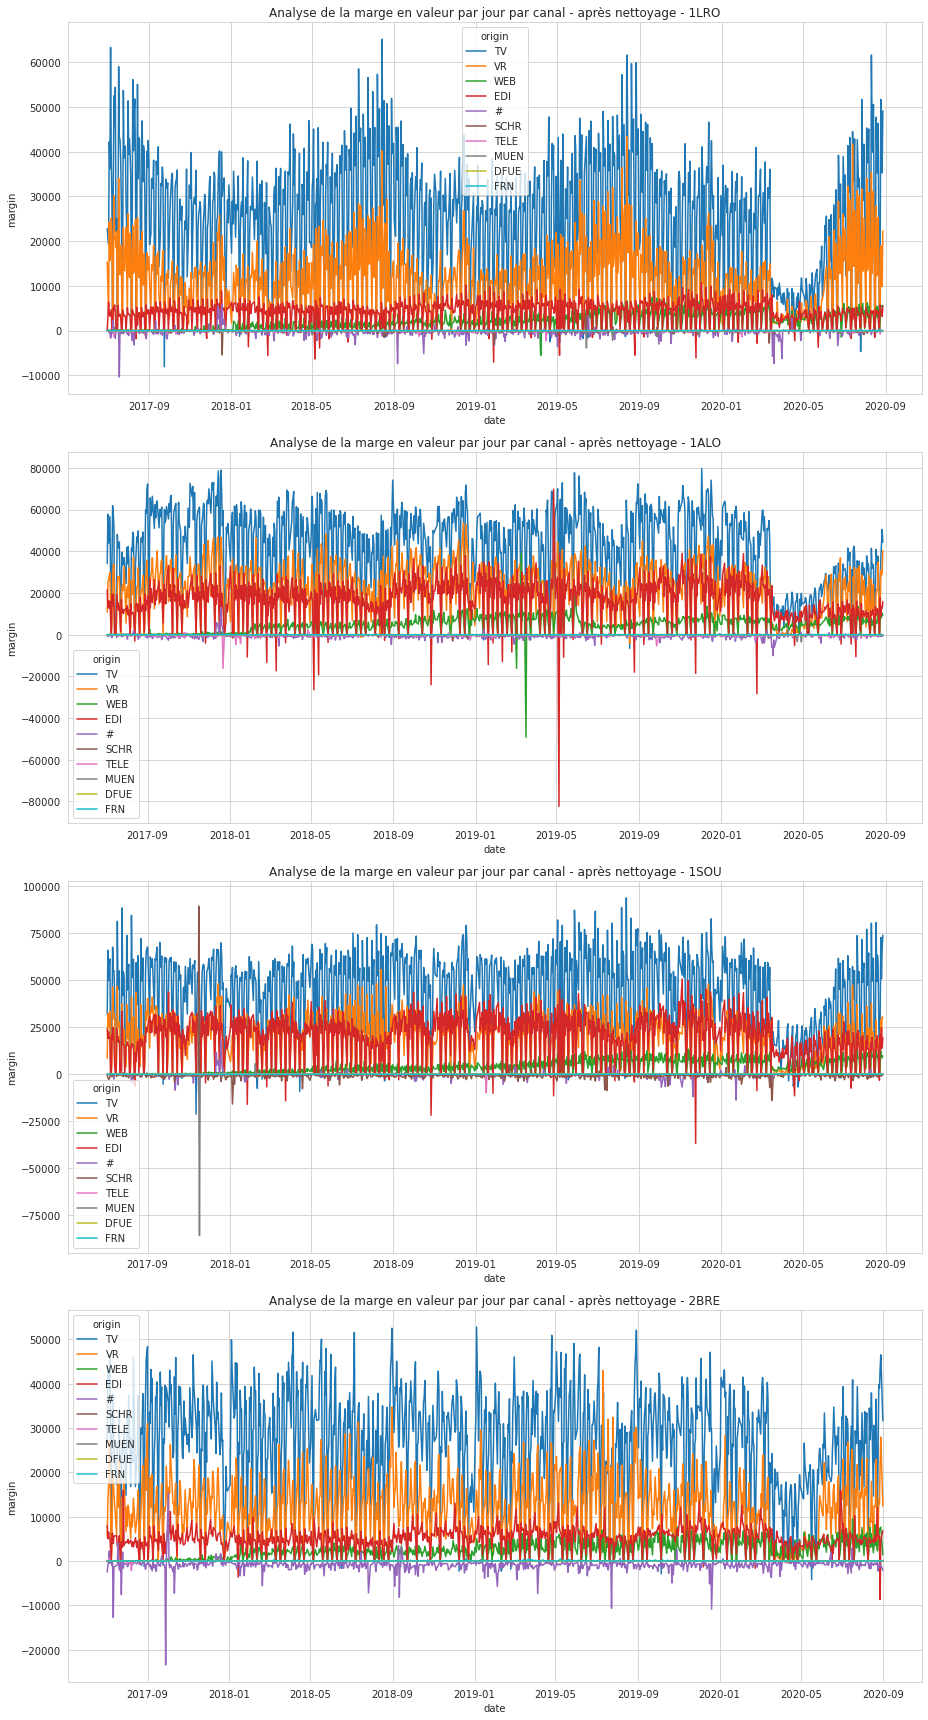

In [29]:
nrows = len(data.orgacom.unique())
fig, axs = plt.subplots(figsize = (13, 6 * nrows), nrows=nrows)
data_to_plot = [(
    data.loc[data.orgacom == orgacom]
        .groupby(['date', 'origin'])['margin']
        .sum()
        .unstack('origin')
        .fillna(0.)
        .rolling(1, win_type='triang')
        .mean()
        .stack('origin')
        .rename('margin')
        .reset_index()
) for orgacom in data.orgacom.unique()]

for i, data_ in enumerate(data_to_plot):
    sns.lineplot(data=data_,
                 x='date',
                 y='margin',
                 hue='origin',
                 hue_order=mult_origins_order,
                 ax=axs[i])
    axs[i].set_title(f'Analyse de la marge en valeur par jour par canal - après nettoyage - {orgacoms[i]}')
fig.tight_layout()

## Persistage sur le disque

In [30]:
data.to_pickle(persist_path / 'small_data.pkl')

## Représentation chronologique des indicateurs

In [31]:
data = pd.read_pickle(persist_path / 'small_data.pkl')

In [32]:
indicator_map = {
    'Marge (€)': 'margin',
    'CA brut (€)': 'brutrevenue',
    'Tonnage (kg)': 'weight',
}

CPU times: user 21.2 s, sys: 9.02 s, total: 30.2 s
Wall time: 30 s


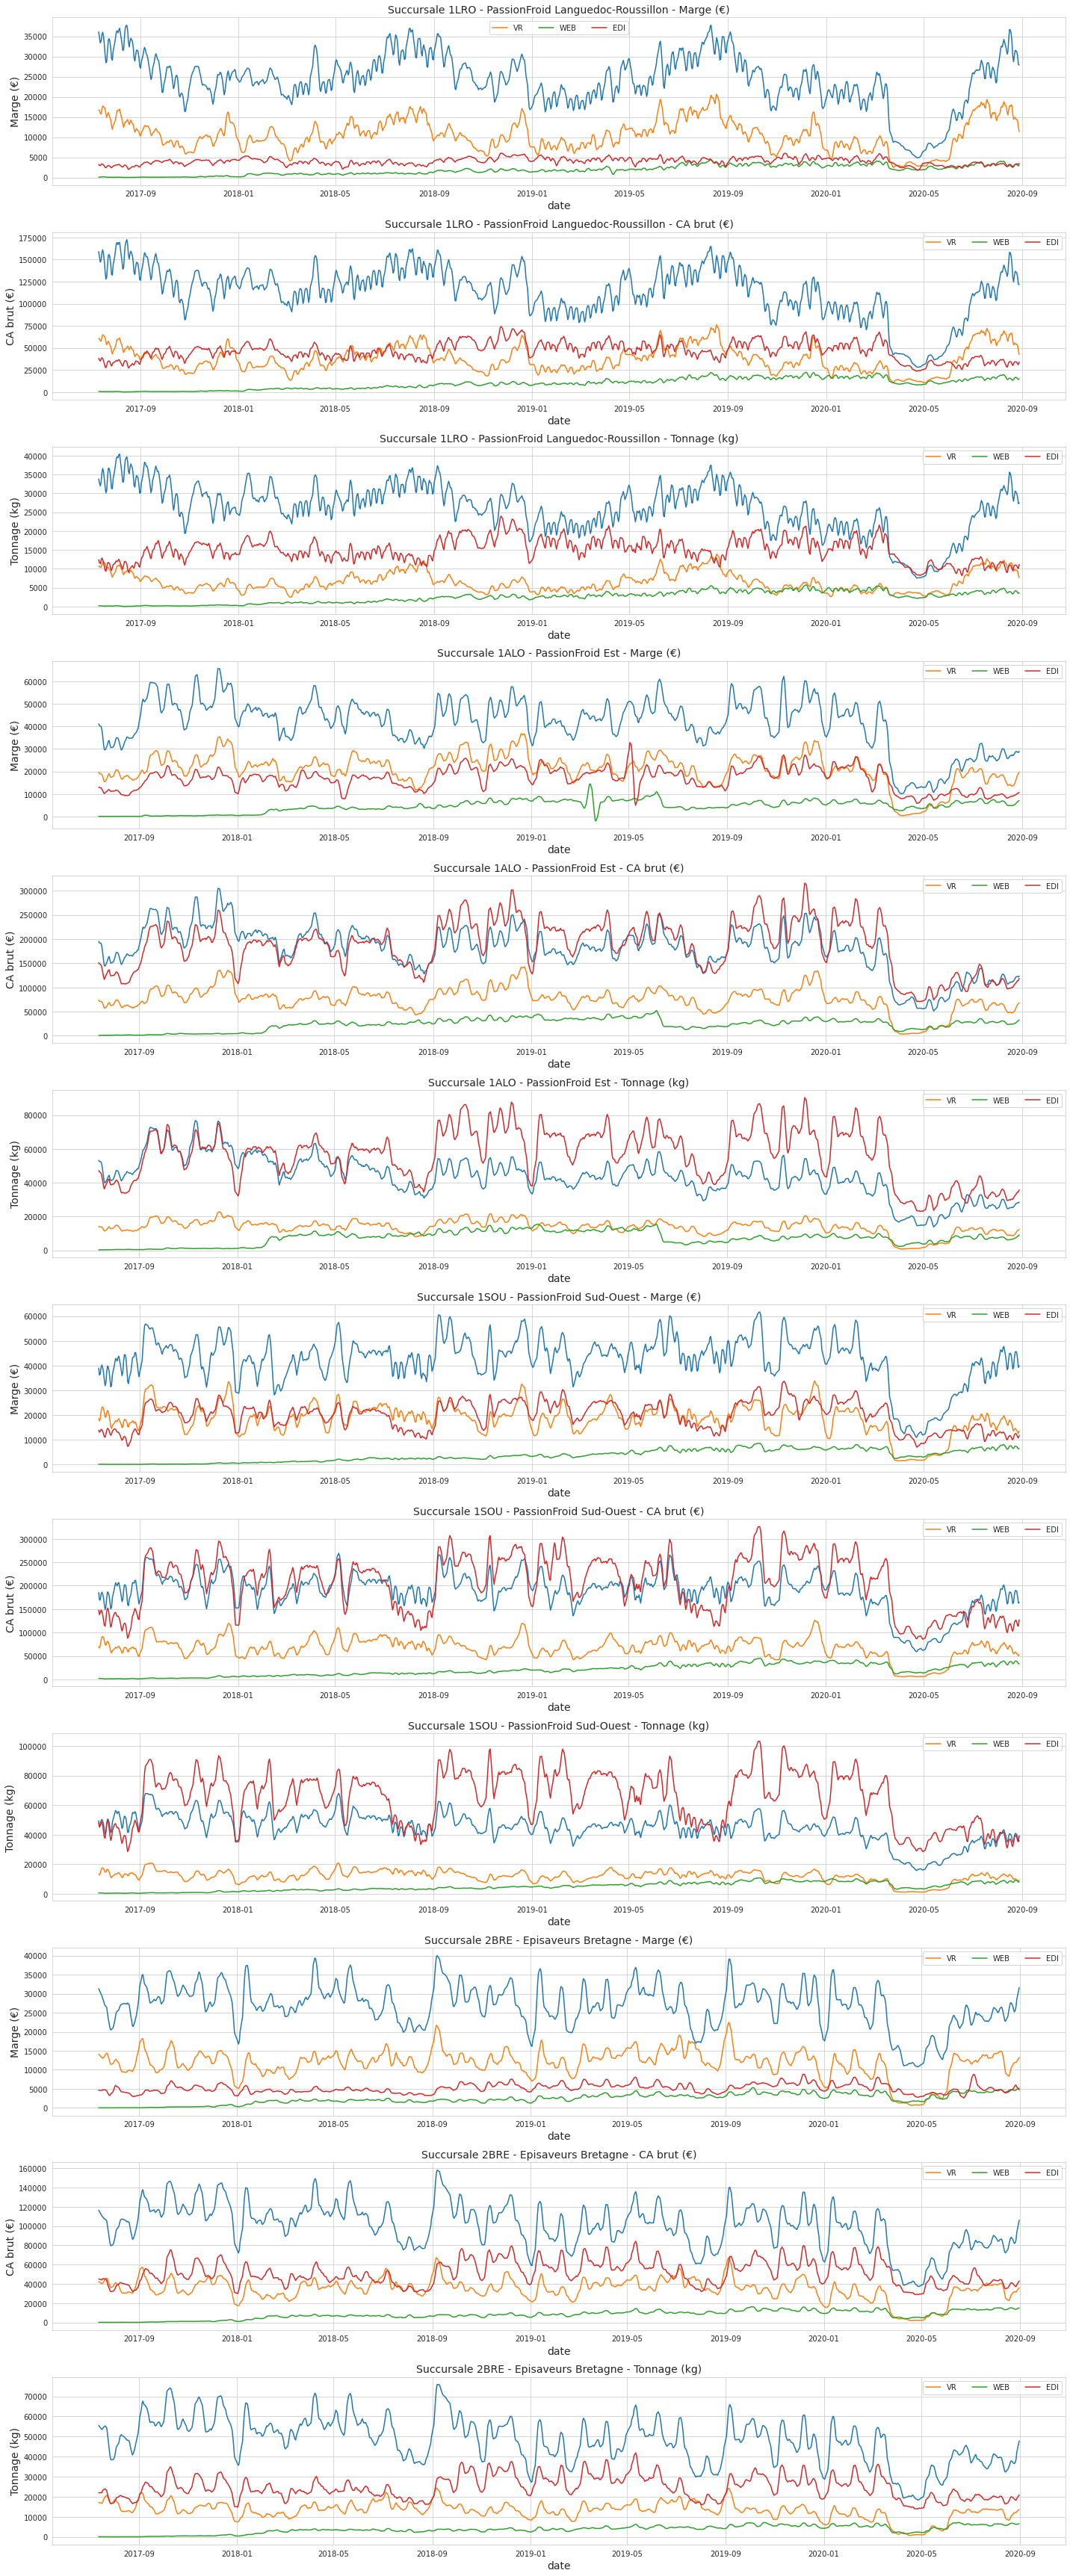

In [33]:
%%time
SV = data['orgacom'].unique()
indicators = ['weight', 'brutrevenue', 'margin']
roll_width = 10
win_type = 'triang'
fig, axs = plt.subplots(figsize=(20, 4 * len(SV)* len(indicator_map)),
                        nrows=len(SV) * len(indicator_map),
#                         squeeze=False,
                       )

for i, suc in enumerate(SV):
    for j, indicator in enumerate(indicator_map):
        
        data_to_plot = (
            data.loc[(data.orgacom == suc) & data.origin.isin(['TV', 'VR', 'WEB', 'EDI'])]
                .groupby(['date', 'origin'], observed=True)[indicator_map[indicator]]
                .sum()
                .unstack('origin')
                .fillna(0.)
                .rolling(roll_width, win_type=win_type)
                .mean()
                .stack('origin')
                .rename(indicator)
                .sort_index()
                .reset_index())
        sns.lineplot(data=data_to_plot,
                     x='date',
                     y=indicator,
                     hue='origin',
                     hue_order=mult_origins_order[:4],                     
                     ax=axs[i * len(indicator_map) + j])
        handles, labels = axs[i * len(indicator_map) + j].get_legend_handles_labels()
        handles = handles[1:]
        labels = labels[1:]
        axs[i * len(indicator_map) + j].legend(handles, labels, ncol=4, )
        axs[i * len(indicator_map) + j].set_title(f'Succursale {utils.lib(suc)} - {indicator}', fontsize=14)
        axs[i * len(indicator_map) + j].xaxis.label.set_fontsize(14)
        axs[i * len(indicator_map) + j].yaxis.label.set_fontsize(14)
        
fig.tight_layout()

## Filtration des canaux "exotiques"

In [34]:
origin2_cat = pd.CategoricalDtype(['TV', 'VR', 'EDI', 'WEB'], ordered=True)
data['origin2'] = data.origin.astype(origin2_cat)

## Aggrégation à la maille de la commande et calcul du canal majoritaire par jour

In [35]:
aggfuncs = {
    'margin': 'sum', 
    'brutrevenue': 'sum',
    'weight': 'sum',
    'origin2': 'size',
}
orders = (
    data.loc[(data.doctype == 'ZC10') & (data.weight > 0.) & (data.brutrevenue > 0.)]
        .groupby(['orgacom', 'date', 'client', 'origin2'], observed=True)
        .agg(aggfuncs)
        .rename({'origin2': 'linecount'}, axis=1)
)
print(f'{len(orders)} records in order dataframe before canal deduplication')
orders

2751677 records in order dataframe before canal deduplication


margin  brutrevenue   weight  linecount
orgacom date       client     origin2                                         
1SOU    2017-07-03 0000065940 TV        31.16        84.01    5.501          9
                   0000065945 TV         6.02        23.69    3.734          2
                   0000065975 TV        25.15        97.40   13.718          1
                   0000065998 TV         4.12         8.56    1.000          1
                   0000066014 TV        17.89        48.30    5.000          1
...                                       ...          ...      ...        ...
2BRE    2020-08-31 0000285226 VR         1.38        10.16   10.000          2
                   SL001W     TV        89.34       555.25  180.000          4
                   SL0041     TV        28.42      1470.00    7.200          1
                   SL0075     TV        12.76        95.03   15.615         11
                   SL009N     TV        10.51        75.03   40.500          1

[2751677 rows x 4 columns]

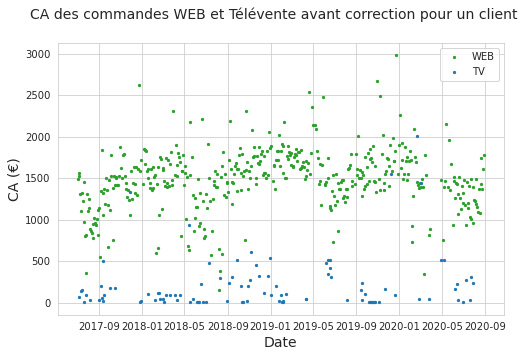

In [36]:
fig, ax = plt.subplots(figsize=(8, 5))
temp = (orders.reset_index()
              .set_index(['orgacom', 'date', 'client', 'origin2'])
              .loc[idx[:, :, '0000200584', :]]
              .reset_index()
       )
ax.scatter(x=temp.loc[temp.origin2 == 'WEB'].date,
           y=temp.loc[temp.origin2 == 'WEB'].brutrevenue,
           color=list(mcolor.TABLEAU_COLORS.values())[2],
           s=5.,
           label='WEB')
ax.scatter(x=temp.loc[temp.origin2 == 'TV'].date,
           y=temp.loc[temp.origin2 == 'TV'].brutrevenue,
           color=list(mcolor.TABLEAU_COLORS.values())[0],
           s=5.,
           label='TV')
del(temp)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('CA (€)', fontsize=14)
fig.suptitle('CA des commandes WEB et Télévente avant correction pour un client', fontsize=14)
ax.legend()


On considère le canal de la commande comme étant le canal qui représente le plus en poids pour un jour donné.

In [37]:
df_before = orders[['margin', 'brutrevenue', 'weight']].groupby('origin2').agg(['sum', 'size'])
df_before

margin            brutrevenue                 weight         
                  sum     size           sum     size           sum     size
origin2                                                                     
TV       1.317671e+08  1500784  5.656508e+08  1500784  1.561315e+08  1500784
VR       6.039799e+07   542186  2.090946e+08   542186  4.364318e+07   542186
EDI      4.404536e+07   602003  4.681359e+08   602003  1.542627e+08   602003
WEB      1.190551e+07   106704  5.908175e+07   106704  1.764510e+07   106704

In [38]:
major_canal = orders['weight'].unstack(fill_value=0.).idxmax(axis=1).rename('origin2')
major_canal

orgacom  date        client    
1SOU     2017-07-03  0000065940     TV
                     0000065945     TV
                     0000065975     TV
                     0000065998     TV
                     0000066014     TV
                                  ... 
2BRE     2020-08-31  0000282373    EDI
                     0000283953    EDI
                     0000284089     TV
                     0000284540     TV
                     0000284735     VR
Name: origin2, Length: 2444326, dtype: object

In [39]:
orders = orders.groupby(level=[0, 1, 2], observed=True).sum().join(major_canal)
del(major_canal)
order_count = len(orders)
print(f'{order_count} records in order dataframe after canal deduplication')
orders

2444326 records in order dataframe after canal deduplication


margin  brutrevenue   weight  linecount origin2
orgacom date       client                                                     
1SOU    2017-07-03 0000065940   31.16        84.01    5.501          9      TV
                   0000065945    6.02        23.69    3.734          2      TV
                   0000065975   25.15        97.40   13.718          1      TV
                   0000065998    4.12         8.56    1.000          1      TV
                   0000066014   17.89        48.30    5.000          1      TV
...                               ...          ...      ...        ...     ...
2BRE    2020-08-31 0000285226  103.91       433.56   80.455         24      TV
                   SL001W       89.34       555.25  180.000          4      TV
                   SL0041       28.42      1470.00    7.200          1      TV
                   SL0075       12.76        95.03   15.615         11      TV
                   SL009N       10.51        75.03   40.500          1      TV

[2444326 rows x 5 columns]

In [40]:
df_after = orders[['margin', 'brutrevenue', 'weight', 'origin2']].groupby('origin2').agg(['sum', 'size'])
df_after

margin            brutrevenue                 weight         
                  sum     size           sum     size           sum     size
origin2                                                                     
EDI      4.502484e+07   596597  4.774257e+08   596597  1.561118e+08   596597
TV       1.304158e+08  1263539  5.590400e+08  1263539  1.547604e+08  1263539
VR       6.033405e+07   485707  2.041264e+08   485707  4.274764e+07   485707
WEB      1.234133e+07    98483  6.137103e+07    98483  1.806270e+07    98483

In [41]:
assert (df_after - df_before).loc[:, idx[:, 'sum']].sum(axis=0).max() < 0.001

In [42]:
(df_after - df_before).loc[:, 'brutrevenue'].style.format({'sum': '{:.2f} €'})

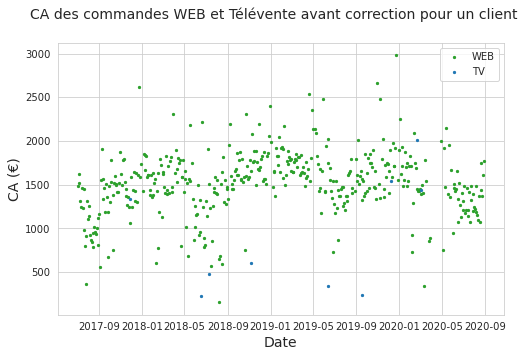

In [43]:
fig, ax = plt.subplots(figsize=(8, 5))
temp = (orders.reset_index()
              .set_index(['orgacom', 'date', 'client', 'origin2'])
              .loc[idx[:, :, '0000200584', :]]
              .reset_index()
       )
ax.scatter(x=temp.loc[temp.origin2 == 'WEB'].date,
           y=temp.loc[temp.origin2 == 'WEB'].brutrevenue,
           color=list(mcolor.TABLEAU_COLORS.values())[2],
           s=5.,
           label='WEB')
ax.scatter(x=temp.loc[temp.origin2 == 'TV'].date,
           y=temp.loc[temp.origin2 == 'TV'].brutrevenue,
           color=list(mcolor.TABLEAU_COLORS.values())[0],
           s=5.,
           label='TV')
del(temp)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('CA (€)', fontsize=14)
fig.suptitle('CA des commandes WEB et Télévente avant correction pour un client', fontsize=14)
ax.legend()


In [44]:
orders.to_pickle(persist_path / 'small_orders.pkl')

## Ajout de la segmentation et de la hiérarchie

On recharge le dataframe des commandes

In [45]:
orders = pd.read_pickle(persist_path / 'small_orders.pkl')
orders

margin  brutrevenue   weight  linecount origin2
orgacom date       client                                                     
1SOU    2017-07-03 0000065940   31.16        84.01    5.501          9      TV
                   0000065945    6.02        23.69    3.734          2      TV
                   0000065975   25.15        97.40   13.718          1      TV
                   0000065998    4.12         8.56    1.000          1      TV
                   0000066014   17.89        48.30    5.000          1      TV
...                               ...          ...      ...        ...     ...
2BRE    2020-08-31 0000285226  103.91       433.56   80.455         24      TV
                   SL001W       89.34       555.25  180.000          4      TV
                   SL0041       28.42      1470.00    7.200          1      TV
                   SL0075       12.76        95.03   15.615         11      TV
                   SL009N       10.51        75.03   40.500          1      TV

[2444326 rows x 5 columns]

On ajoute quelques données du dataset client.

In [46]:
orders = (
    orders
    .reset_index('orgacom')
    .astype({'orgacom': 'object'})
    .set_index('orgacom', append=True)
    .reorder_levels(['orgacom', 'date', 'client'])
)
df_clt = (
    df_clt
    .reset_index('orgacom')
    .astype({'orgacom': 'object'})
    .set_index('orgacom', append=True)
    .reorder_levels(['orgacom', 'client'])
)

In [47]:
clt_fields = ['seg1', 'seg2', 'seg3', 'seg4', 'cat', 'sscat', 'hier4', 'groupecompte', 'relationtype', 'pilcom']
for field in clt_fields:
    try:
        orders = orders.drop(field)
    except: 
        pass
order_count = len(orders)
orders = orders.merge(df_clt.loc[:, clt_fields], left_on=['orgacom', 'client'], right_index=True, validate='m:1')
if len(orders) != order_count:
    raise RuntimeError('Something went wrong when merging orders with client master data!')
orders = (
    orders
    .reset_index('orgacom')
    .astype({'orgacom': 'category'})
    .set_index('orgacom', append=True)
    .reorder_levels(['orgacom', 'date', 'client'])
)
orders

margin  brutrevenue   weight  linecount  \
orgacom date       client                                                
1SOU    2017-07-03 0000065940   31.16        84.01    5.501          9   
        2017-08-28 0000065940   44.36       105.93    8.048         10   
        2017-09-08 0000065940   17.60        40.35    3.000          2   
        2017-09-15 0000065940  100.12       236.77   20.312          3   
        2017-09-25 0000065940   96.04       253.99   40.338          5   
...                               ...          ...      ...        ...   
2BRE    2020-08-31 0000282373  177.42      1401.58  488.036         88   
                   0000283953   43.79       421.67  564.980         28   
                   0000284089   89.39       186.75   90.200         12   
                   0000284540  262.04      1252.07  639.326         97   
                   0000284735  319.24       782.56  235.236         58   

                              origin2 seg1 seg2 seg3 seg4 cat sscat  hier4  \
orgacom date       client                                                    
1SOU    2017-07-03 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897   
        2017-08-28 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897   
        2017-09-08 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897   
        2017-09-15 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897   
        2017-09-25 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897   
...                               ...  ...  ...  ...  ...  ..   ...    ...   
2BRE    2020-08-31 0000282373     EDI   Z3   Z4   ZJ   ZF  ZP    ZA  10705   
                   0000283953     EDI   Z3   Z4   ZJ   ZF  ZN   Z19  10506   
                   0000284089      TV   Z3   Z5   ZK   ZG  ZU   Z43    NaN   
                   0000284540      TV   Z3   Z4   ZJ   ZF  ZP    ZA  10432   
                   0000284735      VR   Z3   Z5   ZK   ZG  ZU    ZN    NaN   

                              groupecompte relationtype pilcom  
orgacom date       client                                       
1SOU    2017-07-03 0000065940         ZCLT          NDI    RGL  
        2017-08-28 0000065940         ZCLT          NDI    RGL  
        2017-09-08 0000065940         ZCLT          NDI    RGL  
        2017-09-15 0000065940         ZCLT          NDI    RGL  
        2017-09-25 0000065940         ZCLT          NDI    RGL  
...                                    ...          ...    ...  
2BRE    2020-08-31 0000282373         ZCRC          DIR    BIG  
                   0000283953         ZCRC          DIR    NTL  
                   0000284089         ZCLT          NDI    RGL  
                   0000284540         ZCRC          DIR    NTL  
                   0000284735         ZCHN          NDI    RGL  

[2444326 rows x 15 columns]

## Calcul des indicateurs composites

In [48]:
composite_indicators_dict = utils.composite_indicators_dict

for indicator, components in composite_indicators_dict.items():
    try:
        orders[indicator] = orders[components[0]] / orders[components[1]]
    except KeyError:
        pass

orders = orders.reset_index()
orders['branch'] = orders['orgacom'].str[0].map({
    '1': 'PPF',
    '2': 'PES',
    }
)
orders.to_pickle(persist_path / 'small_full_orders.pkl')
orders

orgacom       date      client  margin  brutrevenue   weight  \
0          1SOU 2017-07-03  0000065940   31.16        84.01    5.501   
1          1SOU 2017-08-28  0000065940   44.36       105.93    8.048   
2          1SOU 2017-09-08  0000065940   17.60        40.35    3.000   
3          1SOU 2017-09-15  0000065940  100.12       236.77   20.312   
4          1SOU 2017-09-25  0000065940   96.04       253.99   40.338   
...         ...        ...         ...     ...          ...      ...   
2444321    2BRE 2020-08-31  0000282373  177.42      1401.58  488.036   
2444322    2BRE 2020-08-31  0000283953   43.79       421.67  564.980   
2444323    2BRE 2020-08-31  0000284089   89.39       186.75   90.200   
2444324    2BRE 2020-08-31  0000284540  262.04      1252.07  639.326   
2444325    2BRE 2020-08-31  0000284735  319.24       782.56  235.236   

         linecount origin2 seg1 seg2  ... sscat  hier4 groupecompte  \
0                9      TV   Z3   Z4  ...   Z13  10897         ZCLT   
1               10      TV   Z3   Z4  ...   Z13  10897         ZCLT   
2                2      TV   Z3   Z4  ...   Z13  10897         ZCLT   
3                3      TV   Z3   Z4  ...   Z13  10897         ZCLT   
4                5      TV   Z3   Z4  ...   Z13  10897         ZCLT   
...            ...     ...  ...  ...  ...   ...    ...          ...   
2444321         88     EDI   Z3   Z4  ...    ZA  10705         ZCRC   
2444322         28     EDI   Z3   Z4  ...   Z19  10506         ZCRC   
2444323         12      TV   Z3   Z5  ...   Z43    NaN         ZCLT   
2444324         97      TV   Z3   Z4  ...    ZA  10432         ZCRC   
2444325         58      VR   Z3   Z5  ...    ZN    NaN         ZCHN   

        relationtype pilcom       PMVK marginperkg marginpercent  lineweight  \
0                NDI    RGL  15.271769    5.664425      0.370908    0.611222   
1                NDI    RGL  13.162276    5.511928      0.418767    0.804800   
2                NDI    RGL  13.450000    5.866667      0.436183    1.500000   
3                NDI    RGL  11.656656    4.929106      0.422858    6.770667   
4                NDI    RGL   6.296544    2.380882      0.378125    8.067600   
...              ...    ...        ...         ...           ...         ...   
2444321          DIR    BIG   2.871878    0.363539      0.126586    5.545864   
2444322          DIR    NTL   0.746345    0.077507      0.103849   20.177857   
2444323          NDI    RGL   2.070399    0.991020      0.478661    7.516667   
2444324          DIR    NTL   1.958422    0.409869      0.209285    6.590990   
2444325          NDI    RGL   3.326702    1.357105      0.407943    4.055793   

         branch  
0           PPF  
1           PPF  
2           PPF  
3           PPF  
4           PPF  
...         ...  
2444321     PES  
2444322     PES  
2444323     PES  
2444324     PES  
2444325     PES  

[2444326 rows x 23 columns]

## Affichage des indicateurs sur l'année 2019

In [49]:
reload(utils)

<module 'scripts.utils' from '/homedm/pmasse/WebOrNot/scripts/utils.py'>

In [50]:
orders = pd.read_pickle(persist_path / 'small_full_orders.pkl')
orders

orgacom       date      client  margin  brutrevenue   weight  \
0          1SOU 2017-07-03  0000065940   31.16        84.01    5.501   
1          1SOU 2017-08-28  0000065940   44.36       105.93    8.048   
2          1SOU 2017-09-08  0000065940   17.60        40.35    3.000   
3          1SOU 2017-09-15  0000065940  100.12       236.77   20.312   
4          1SOU 2017-09-25  0000065940   96.04       253.99   40.338   
...         ...        ...         ...     ...          ...      ...   
2444321    2BRE 2020-08-31  0000282373  177.42      1401.58  488.036   
2444322    2BRE 2020-08-31  0000283953   43.79       421.67  564.980   
2444323    2BRE 2020-08-31  0000284089   89.39       186.75   90.200   
2444324    2BRE 2020-08-31  0000284540  262.04      1252.07  639.326   
2444325    2BRE 2020-08-31  0000284735  319.24       782.56  235.236   

         linecount origin2 seg1 seg2  ... sscat  hier4 groupecompte  \
0                9      TV   Z3   Z4  ...   Z13  10897         ZCLT   
1               10      TV   Z3   Z4  ...   Z13  10897         ZCLT   
2                2      TV   Z3   Z4  ...   Z13  10897         ZCLT   
3                3      TV   Z3   Z4  ...   Z13  10897         ZCLT   
4                5      TV   Z3   Z4  ...   Z13  10897         ZCLT   
...            ...     ...  ...  ...  ...   ...    ...          ...   
2444321         88     EDI   Z3   Z4  ...    ZA  10705         ZCRC   
2444322         28     EDI   Z3   Z4  ...   Z19  10506         ZCRC   
2444323         12      TV   Z3   Z5  ...   Z43    NaN         ZCLT   
2444324         97      TV   Z3   Z4  ...    ZA  10432         ZCRC   
2444325         58      VR   Z3   Z5  ...    ZN    NaN         ZCHN   

        relationtype pilcom       PMVK marginperkg marginpercent  lineweight  \
0                NDI    RGL  15.271769    5.664425      0.370908    0.611222   
1                NDI    RGL  13.162276    5.511928      0.418767    0.804800   
2                NDI    RGL  13.450000    5.866667      0.436183    1.500000   
3                NDI    RGL  11.656656    4.929106      0.422858    6.770667   
4                NDI    RGL   6.296544    2.380882      0.378125    8.067600   
...              ...    ...        ...         ...           ...         ...   
2444321          DIR    BIG   2.871878    0.363539      0.126586    5.545864   
2444322          DIR    NTL   0.746345    0.077507      0.103849   20.177857   
2444323          NDI    RGL   2.070399    0.991020      0.478661    7.516667   
2444324          DIR    NTL   1.958422    0.409869      0.209285    6.590990   
2444325          NDI    RGL   3.326702    1.357105      0.407943    4.055793   

         branch  
0           PPF  
1           PPF  
2           PPF  
3           PPF  
4           PPF  
...         ...  
2444321     PES  
2444322     PES  
2444323     PES  
2444324     PES  
2444325     PES  

[2444326 rows x 23 columns]

In [51]:
show(partial(utils.bk_histo_seg,
             source_df=orders.reset_index(),
             segs=['seg1', 'seg2'],
             filters={},
             filters_exclude={'groupecompte': ['ZPER']}, # 'hier4': ['198863']
             plot_kwargs=dict(title="Chiffre d'affaire brut 2019 en fonction de la segmentation niveau 2 et du canal"),
            ),
     notebook_url="http://devdm:8888")

In [52]:
show(partial(utils.bk_histo_seg,
             source_df=orders.reset_index(),
             segs=['seg2', 'seg3'],
             filters={'seg1': ['Z3']},
             filters_exclude={}, #'hier4': ['198863']
             plot_kwargs=dict(title="Chiffre d'affaire brut 2019 RHD en fonction de la segmentation niveau 3 et du canal"),
            ),
     notebook_url="http://devdm:8888") #'seg1': ['Z3']

## Affichage des distributions - par succursale

In [53]:
filter_otacos = (orders.hier4 != '198863')
filter_personnel = (orders.groupecompte != 'ZPER')
filter_rhd = (orders.seg1 == 'Z3')
filter_ppf = (orders.branch == 'PPF')
filter_pes = (orders.branch == 'PES')
filter_main_origins = ~(
    (orders.origin2.isin(['EDI']) & orders.seg3.isin(['ZI', 'ZK'])) |
    (orders.origin2.isin(['VR']) & orders.seg3.isin(['ZJ', 'ZL'])) |
    (orders.origin2.isin(['WEB']) & orders.seg3.isin(['ZJ']))
)
filter_2019 = (
    (orders.date >= pd.to_datetime("01-01-2019")) &
    (orders.date <= pd.to_datetime("31-12-2019"))
)
print(f"Filtrage des origines de commandes minoritaires : \n",
      f"Avant filtration il y avait {len(orders)} commandes\n",
      f"Après filtration il reste {sum(filter_main_origins)} commandes\n",
      f"Soit un delta de {len(orders) - sum(filter_main_origins)} commandes",
      f'({(len(orders) - sum(filter_main_origins)) / len(orders):.2%})',
      )

Filtrage des origines de commandes minoritaires : 
 Avant filtration il y avait 2444326 commandes
 Après filtration il reste 2428615 commandes
 Soit un delta de 15711 commandes (0.64%)


CPU times: user 52.8 s, sys: 22.1 s, total: 1min 14s
Wall time: 44.3 s


Text(0.5, 0.91, 'Analyse des commandes par succursale')

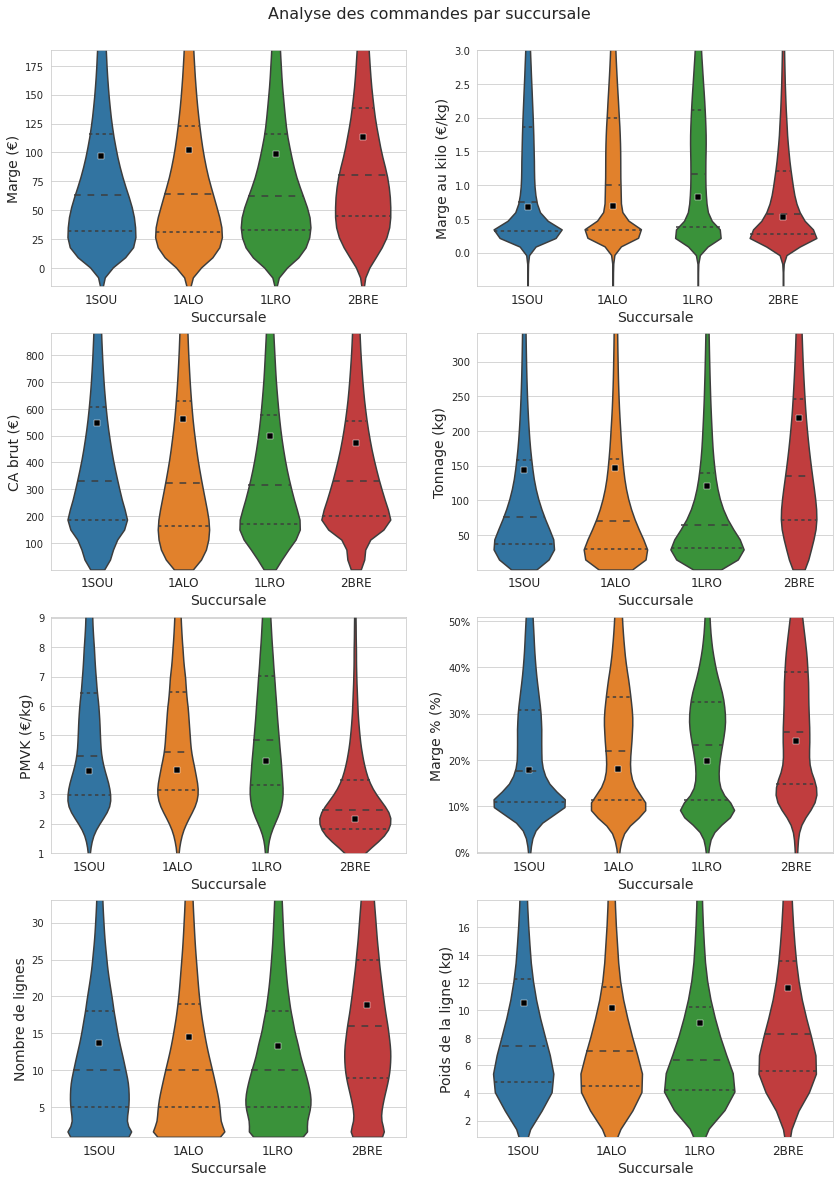

In [54]:
%%time
indicators2 = ['margin', 'brutrevenue',  'PMVK', 'linecount', 'marginperkg', 'weight', 'marginpercent', 'lineweight']
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=None,
                              ncols=2,
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              hue=None,
                              hue_order=None,
                              translate=['xaxis', 'indicator',],                              
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=.5,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(14, 20)
fig.suptitle('Analyse des commandes par succursale', fontsize=16, y=.91)

In [55]:
utils.pretty_means(data=orders.reset_index(), groupers=['orgacom'], indicators=indicators2)

## Affichage des distributions - par canal de vente

CPU times: user 1min 3s, sys: 38.5 s, total: 1min 41s
Wall time: 47.8 s


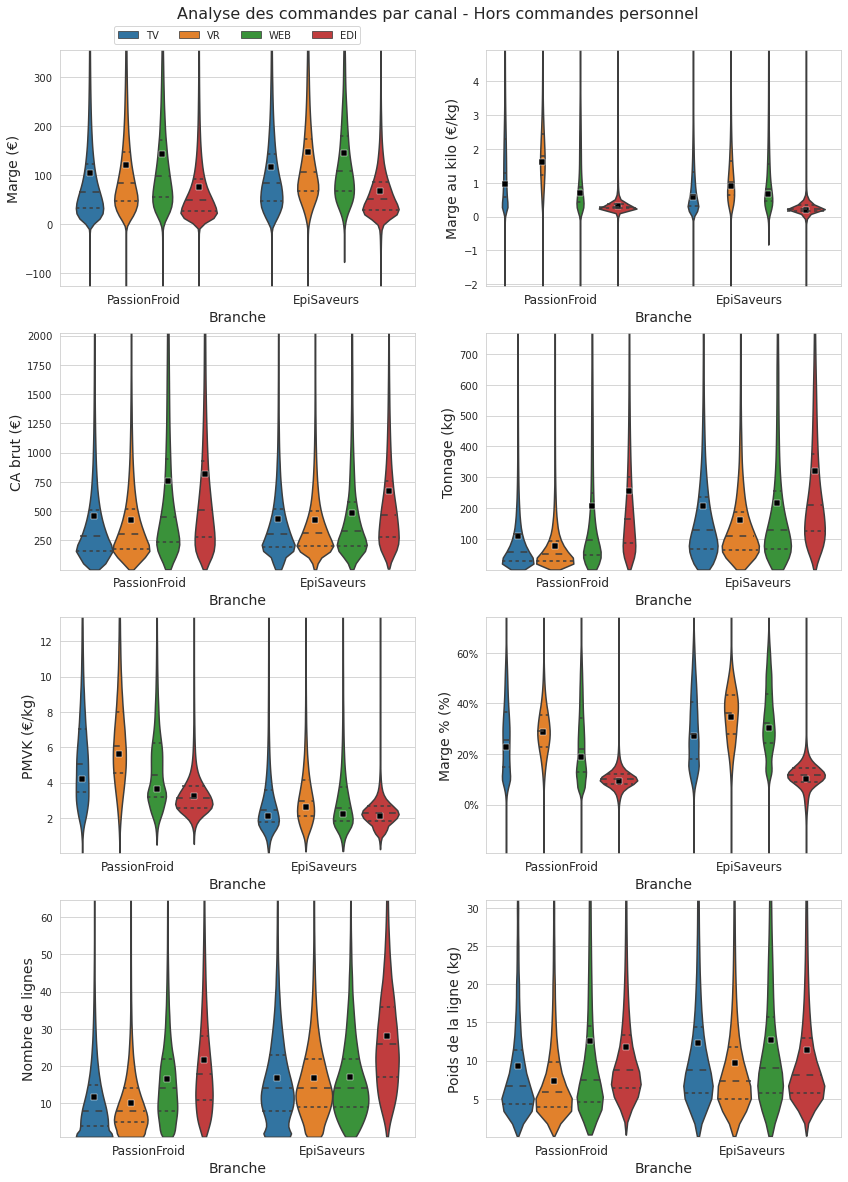

In [56]:
%%time

filters = filter_personnel

fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=filters,
                              ncols=2,
                              x='branch',
                              order=['PPF', 'PES'],
                              translate=True,
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(14, 20)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
fig.suptitle('Analyse des commandes par canal - Hors commandes personnel', fontsize=16, y=.91)
utils.pretty_means(data=orders.loc[filters].reset_index(),
                   groupers=['branch', 'origin2'],
                   indicators=indicators2,
                   translate=['branch', 'columns', 'origin2']
                  )

## Affichage des distributions - par canal de vente - hors O'Tacos

CPU times: user 1min 2s, sys: 37.5 s, total: 1min 40s
Wall time: 46.2 s


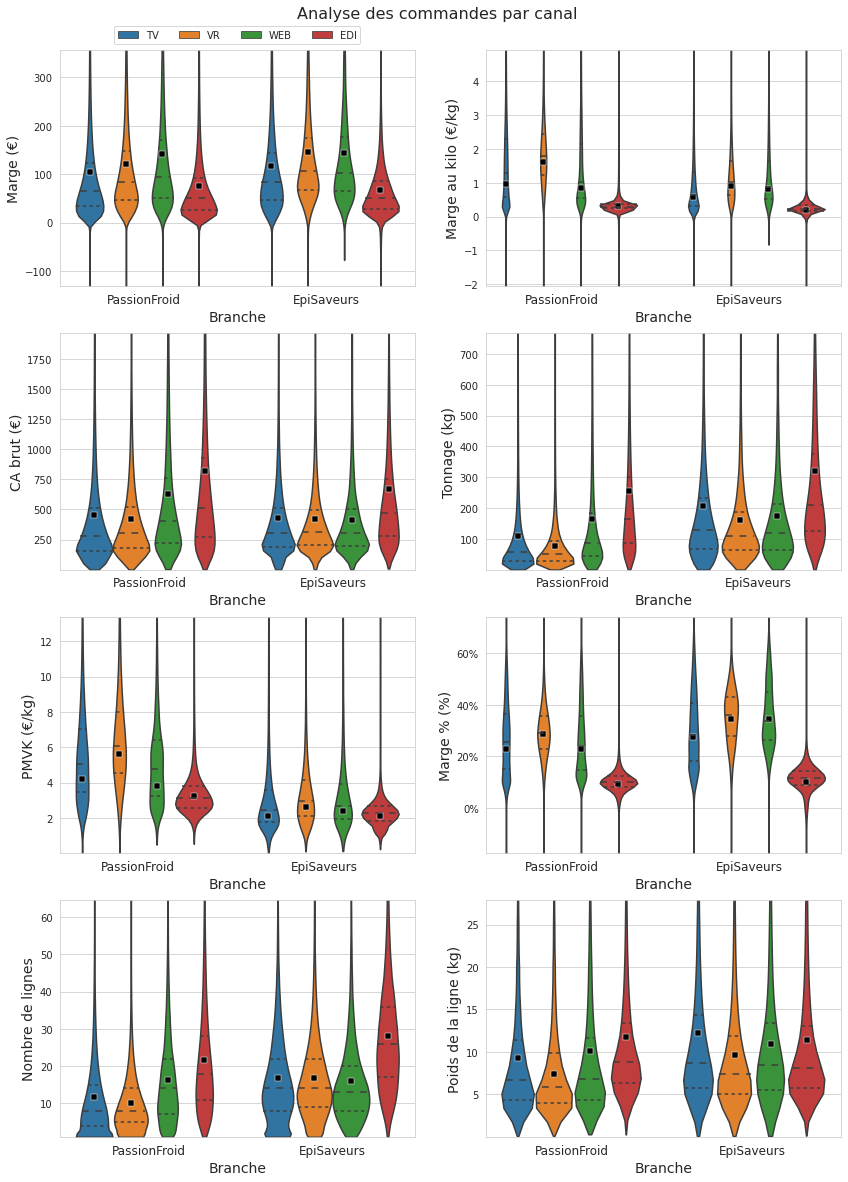

In [57]:
%%time

filters = filter_personnel & filter_otacos

fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=filters,
                              ncols=2,
                              x='branch',
                              order=['PPF', 'PES'],
                              translate=True,
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(14, 20)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
fig.suptitle('Analyse des commandes par canal', fontsize=16, y=.91)
utils.pretty_means(data=orders.loc[filters].reset_index(),
                   groupers=['branch', 'origin2'],
                   indicators=indicators2,
                   translate=['branch', 'columns', 'origin2']
                  )

## Affichage des distributions - par canal de vente - uniquement O'Tacos

CPU times: user 798 ms, sys: 110 ms, total: 908 ms
Wall time: 906 ms


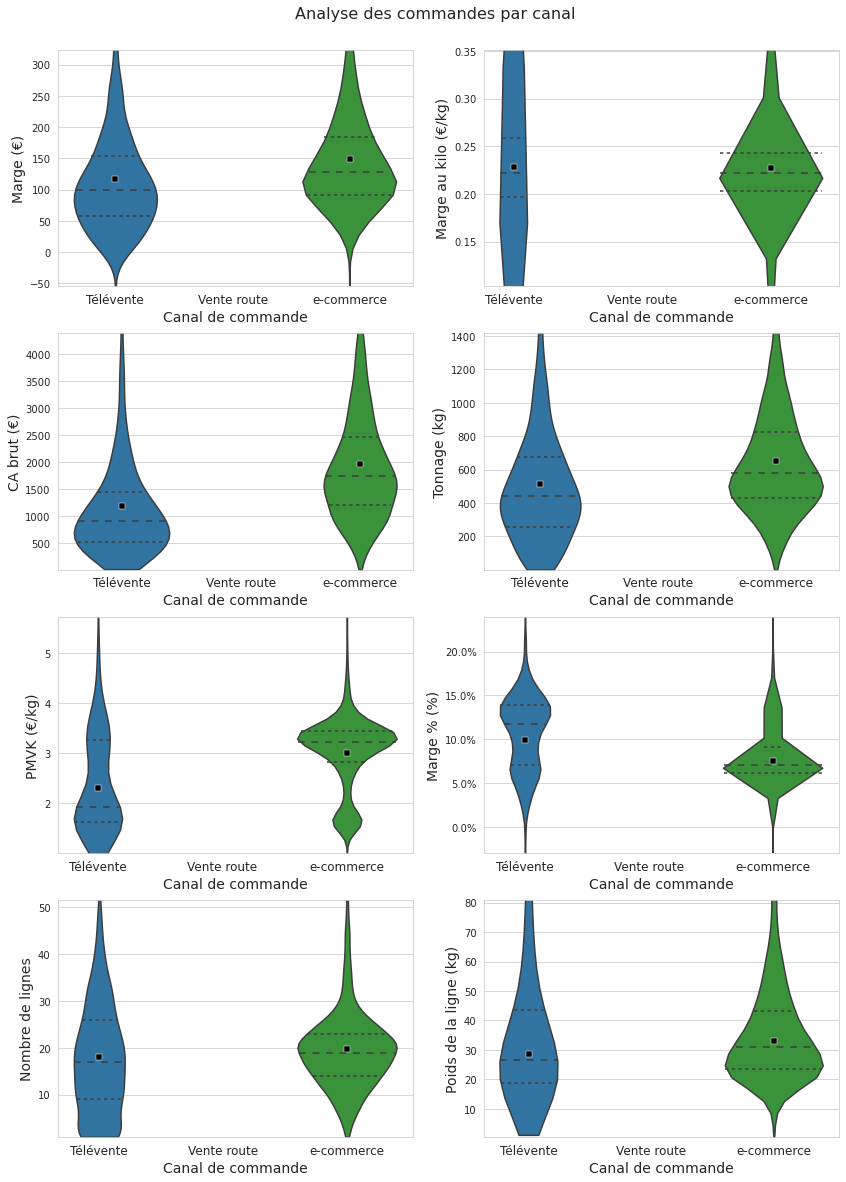

In [58]:
%%time
fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=(~filter_otacos) & (orders.origin2 != 'VR'),
                              ncols=2,
                              x='origin2',
                              order=['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'x', 'indicator'],
                              hue=None,
                              hue_order=None,
                              kind='violin',
                              percentile_selection=1.,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(14, 20)
fig.suptitle('Analyse des commandes par canal', fontsize=16, y=.91)
utils.pretty_means(data=orders.loc[~filter_otacos].reset_index(),
                   groupers=['origin2'],
                   indicators=indicators2,
                   translate=['columns', 'origin2']
                  )

## Affichage des distributions - par canal de vente et succursale

/homedm/pmasse/WebOrNot/scripts/utils.py:640: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


CPU times: user 7.6 s, sys: 938 ms, total: 8.54 s
Wall time: 8.54 s


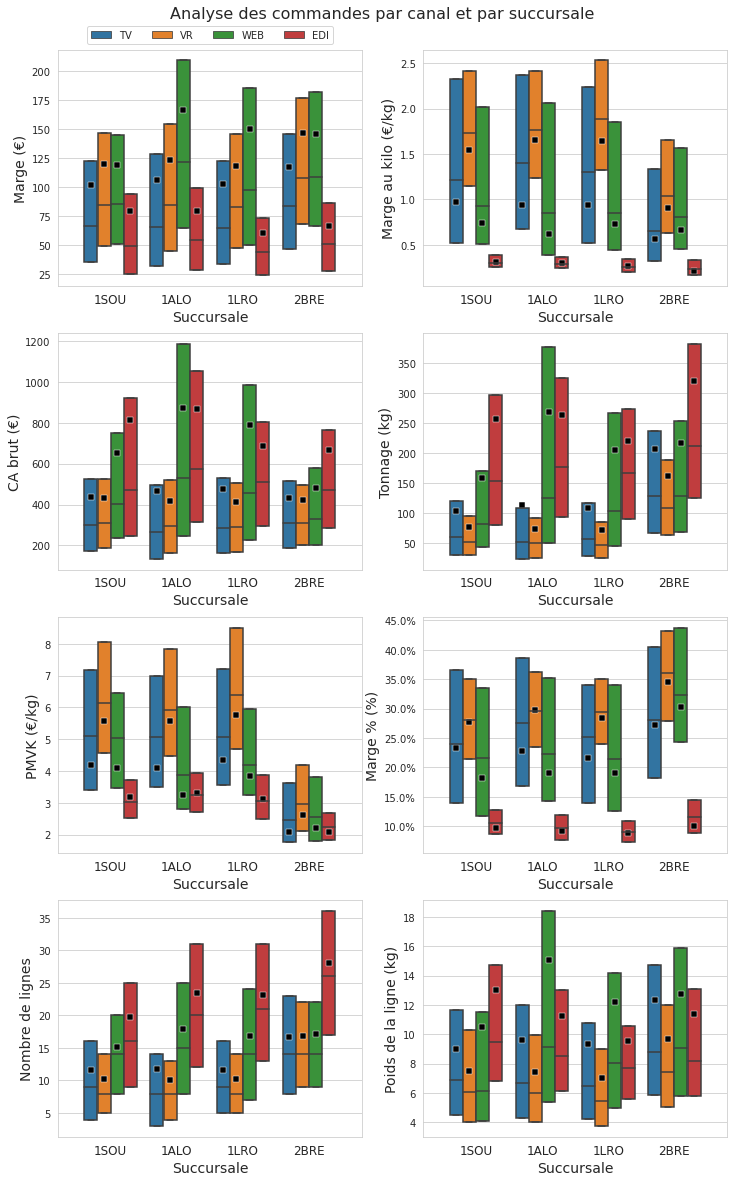

In [59]:
%%time

filters = filter_personnel

fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=filters,
                              ncols=2,
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator',],
                              kind='boxplot',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=None,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(12, 20)
fig.suptitle('Analyse des commandes par canal et par succursale', fontsize=16, y=.91)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
utils.pretty_means(data=orders.loc[filters].reset_index(),
                   groupers=['orgacom', 'origin2'],
                   indicators=indicators2,
                   translate=['columns', 'origin2']
                  )

## Affichage des distributions - par canal de vente et succursale - Hors O'Tacos

/homedm/pmasse/WebOrNot/scripts/utils.py:640: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


CPU times: user 6.83 s, sys: 758 ms, total: 7.58 s
Wall time: 7.58 s


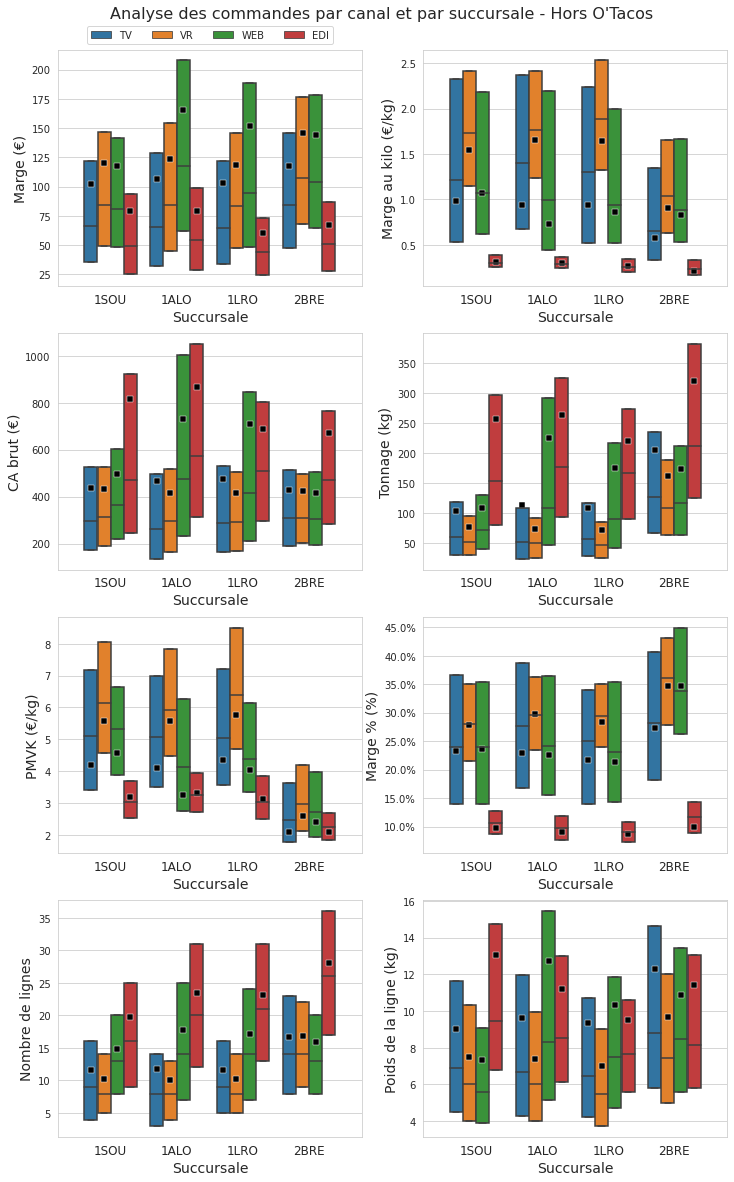

In [60]:
%%time

filters = filter_personnel & filter_otacos

fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=filters,
                              ncols=2,
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator',],
                              kind='boxplot',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=None,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal et par succursale - Hors O'Tacos", fontsize=16, y=.91)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
utils.pretty_means(data=orders.loc[filters].reset_index(),
                   groupers=['orgacom', 'origin2'],
                   indicators=indicators2,
                   translate=['columns', 'origin2']
                  )

## Affichage des distributions - par segment

In [61]:
reload(utils)

<module 'scripts.utils' from '/homedm/pmasse/WebOrNot/scripts/utils.py'>

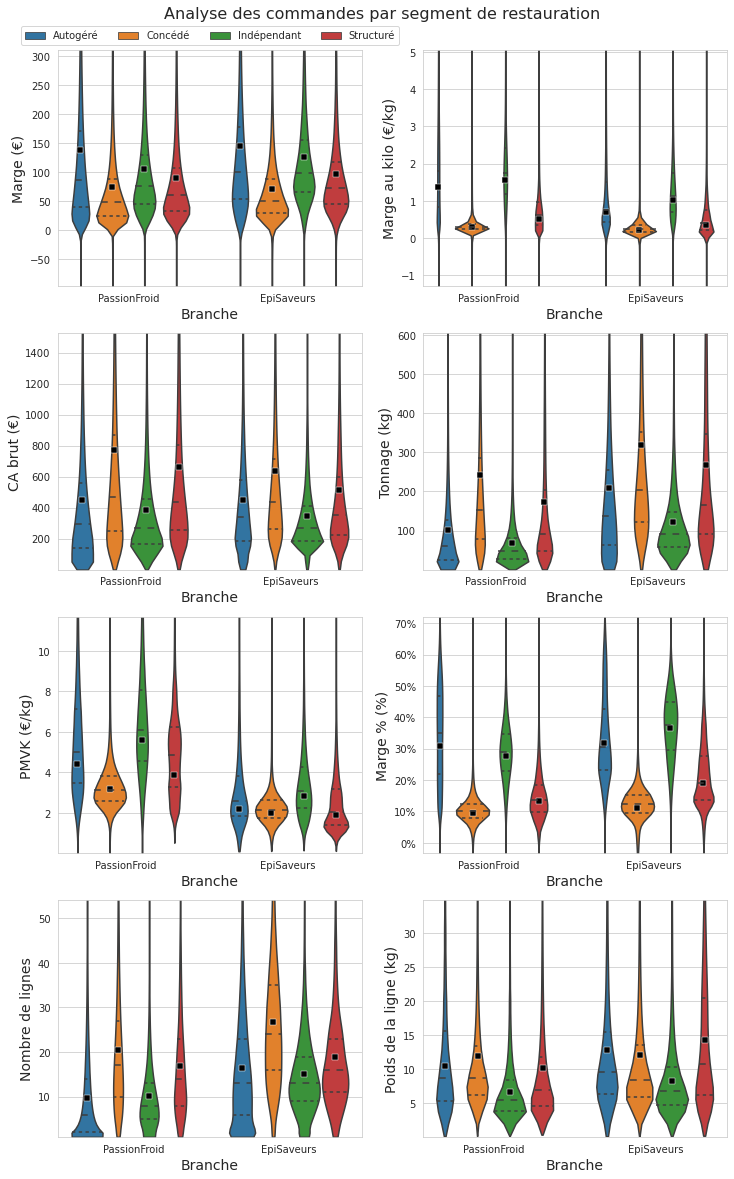

In [62]:
filters = filter_rhd & filter_personnel

fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=(filters),
                              ncols=2,
                              hue='seg3',
                              hue_order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              x='branch',
                              order=['PPF', 'PES'],
                              translate=['xaxis', 'indicator', 'x', 'legend'],
                              kind='violin',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=1.,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
handles, labels = axs[0, 0].get_legend_handles_labels()
labels = map(partial(utils.lib, domain='seg3'), labels)
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
fig.suptitle("Analyse des commandes par segment de restauration", fontsize=16, y=.91)
utils.pretty_means(data=orders[filters].reset_index(),
                   groupers=['branch', 'seg3'],
                   indicators=indicators2,
                   translate=['branch', 'columns', 'seg3']
                  )

## Affichage des distributions - par segment - Hors O'Tacos

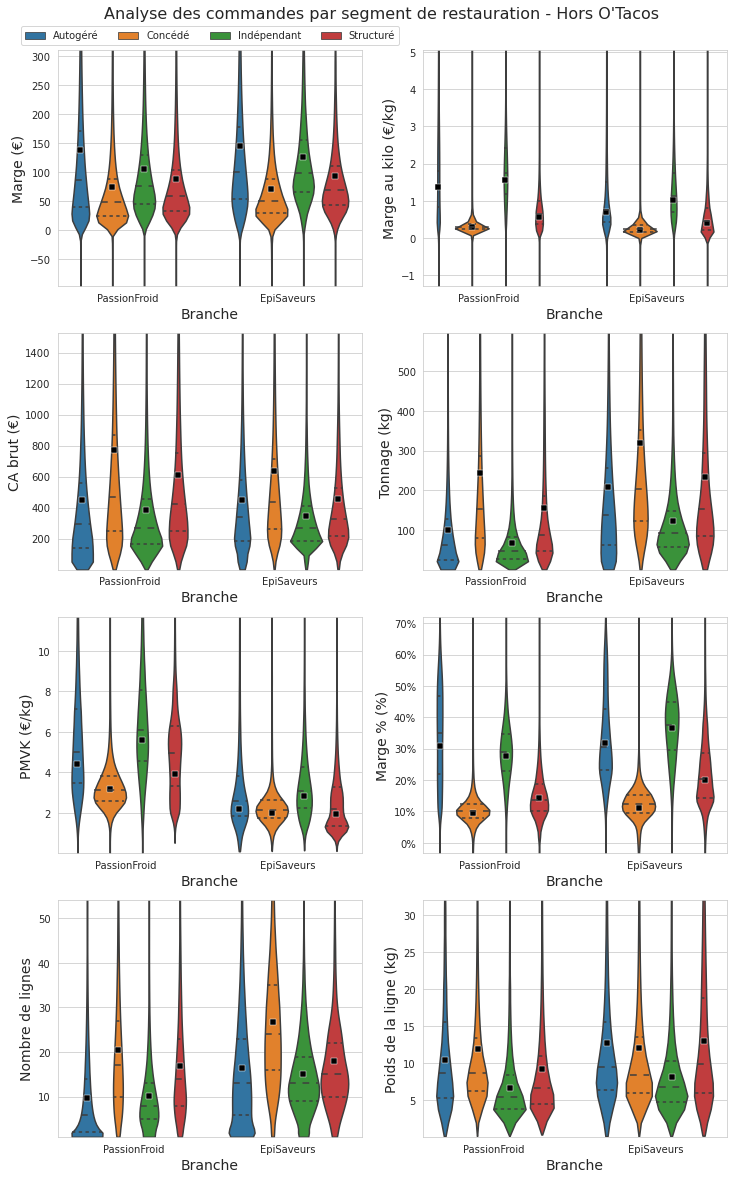

In [63]:
filters = filter_rhd & filter_personnel & filter_otacos

fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=(filters),
                              ncols=2,
                              hue='seg3',
                              hue_order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              x='branch',
                              order=['PPF', 'PES'],
                              translate=['xaxis', 'indicator', 'x', 'legend'],
                              kind='violin',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=1.,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
handles, labels = axs[0, 0].get_legend_handles_labels()
labels = map(partial(utils.lib, domain='seg3'), labels)
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
fig.suptitle("Analyse des commandes par segment de restauration - Hors O'Tacos", fontsize=16, y=.91)
utils.pretty_means(data=orders[filters].reset_index(),
                   groupers=['branch', 'seg3'],
                   indicators=indicators2,
                   translate=['branch', 'columns', 'seg3']
                  )

## Affichage des distributions, par segment et canal de commande - PassionFroid

/homedm/pmasse/WebOrNot/scripts/utils.py:640: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


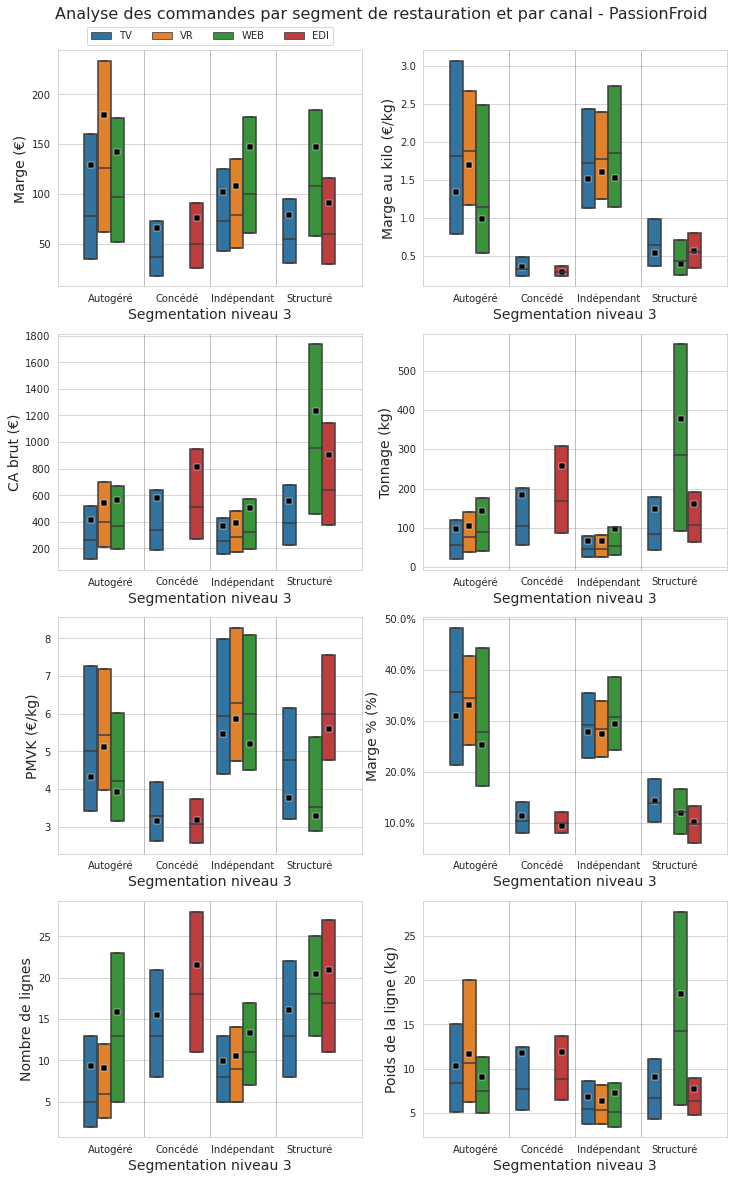

In [64]:
filters = filter_rhd & filter_main_origins & filter_ppf

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=(filters),
                              ncols=2,
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              x='seg3',
                              order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='boxplot',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
#                               IQR_factor_plot=1.,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par segment de restauration et par canal - PassionFroid", fontsize=16, y=.91)
utils.pretty_means(data=orders[filters].reset_index(),
                   groupers=['seg3', 'origin2'],
                   indicators=indicators2,
                   translate=['columns', 'seg3', 'origin2']
                  )
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        for x in [.5, 1.5, 2.5]:
            ax.axvline(x, lw=1, color='grey', alpha=.5)
        ax.get_legend().remove()

## Affichage des distributions, par segment et canal de commande - EpiSaveurs

/homedm/pmasse/WebOrNot/scripts/utils.py:640: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


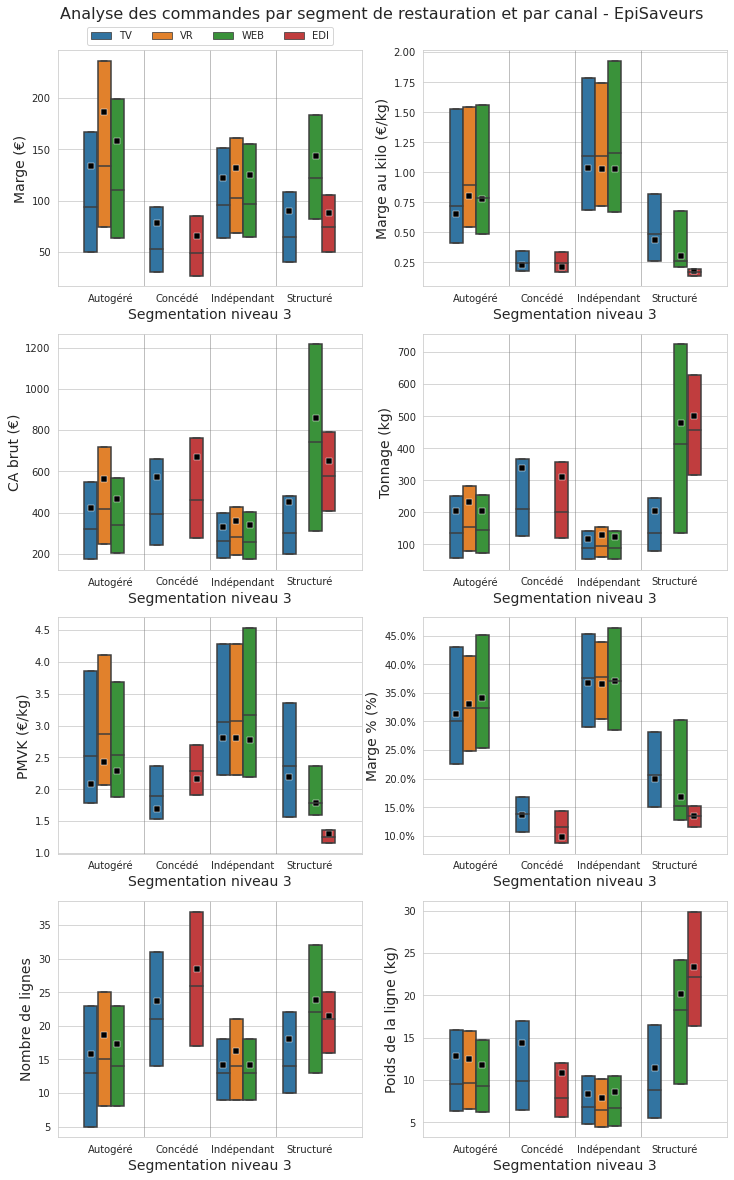

In [65]:
filter_rhd = (orders.seg1 == 'Z3')

filters = filter_rhd & filter_main_origins & filter_pes

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=(filters),
                              ncols=2,
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              x='seg3',
                              order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='boxplot',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
#                               IQR_factor_plot=1.,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par segment de restauration et par canal - EpiSaveurs", fontsize=16, y=.91)
utils.pretty_means(data=orders[filters].reset_index(),
                   groupers=['seg3', 'origin2'],
                   indicators=indicators2,
                   translate=['columns', 'seg3', 'origin2']
                  )
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        for x in [.5, 1.5, 2.5]:
            ax.axvline(x, lw=1, color='grey', alpha=.5)
        ax.get_legend().remove()

## Affichage des distributions, par segment et canal de commande - Hors O'Tacos - PassionFroid

/homedm/pmasse/WebOrNot/scripts/utils.py:640: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


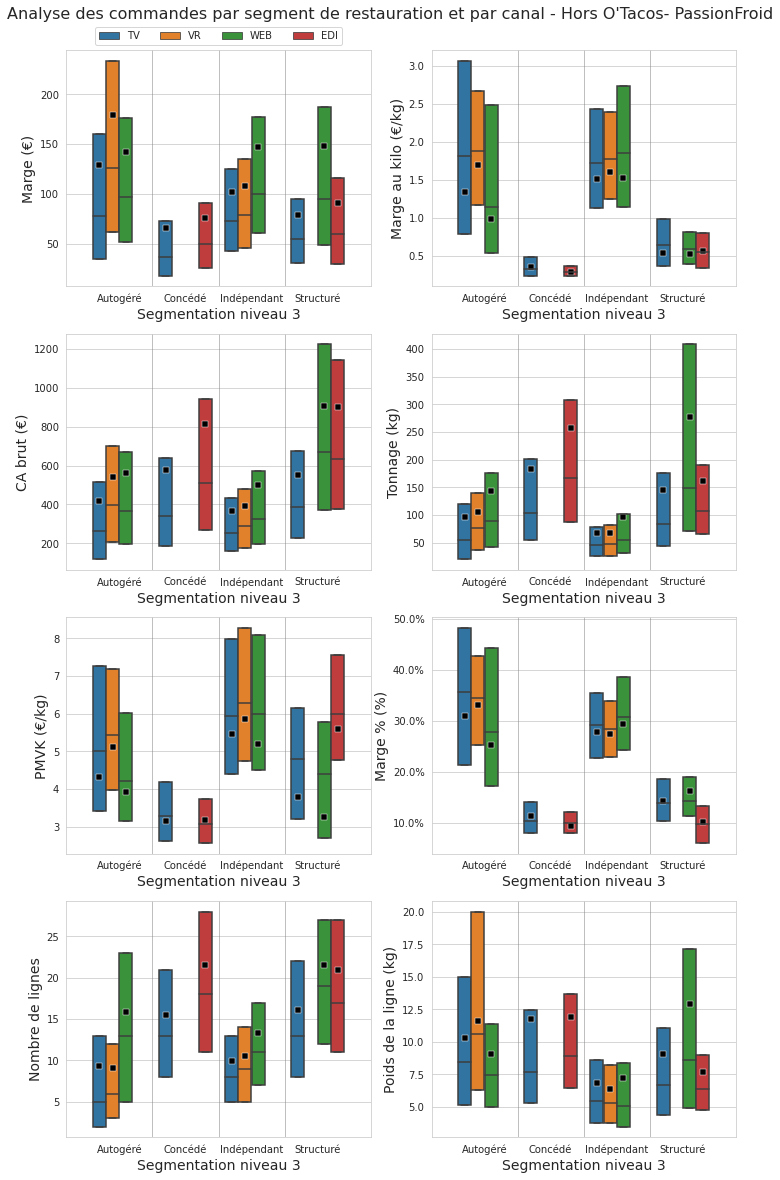

In [66]:
filters = filter_rhd & filter_main_origins & filter_ppf & filter_otacos

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=(filters),
                              ncols=2,
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              x='seg3',
                              order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='boxplot',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
#                               IQR_factor_plot=1.,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle(
    "Analyse des commandes par segment de restauration et par canal - Hors O'Tacos- PassionFroid",
    fontsize=16,
    y=.91
)
utils.pretty_means(data=orders[filters].reset_index(),
                   groupers=['seg3', 'origin2'],
                   indicators=indicators2,
                   translate=['columns', 'seg3', 'origin2']
                  )
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        for x in [.5, 1.5, 2.5]:
            ax.axvline(x, lw=1, color='grey', alpha=.5)
        ax.get_legend().remove()

## Focus sur le PMVK en RCS

Text(0.5, 0.91, 'Analyse des commandes par canal - Focus RCS')

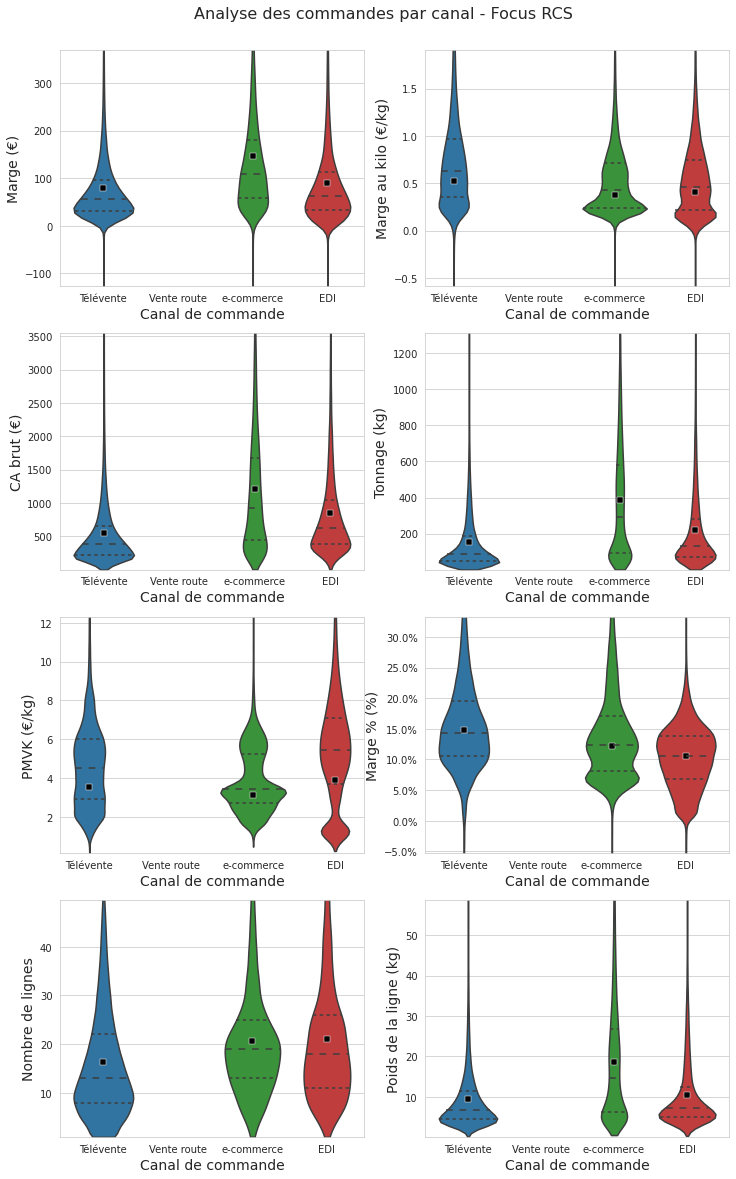

In [67]:
filter_rhd = (orders.seg1 == 'Z3')
filter_rcs = (orders.seg3 == 'ZL')

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=(filter_rcs & filter_main_origins),
                              ncols=2,
                              x='origin2',
                              order=['TV', 'VR', 'WEB', 'EDI'],
#                               x='seg3',
#                               order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='violin',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal - Focus RCS", fontsize=16, y=.91)
# utils.pretty_means(data=orders[filter_rhd & filter_otacos].reset_index(),
#                    groupers=['seg3', 'origin2'],
#                    indicators=indicators2,
#                    translate=['columns', 'seg3', 'origin2']
#                   )
# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
# for ax_list in axs:
#     for ax in ax_list:
#         for x in [.5, 1.5, 2.5]:
#             ax.axvline(x, lw=1, color='grey', alpha=.5)
#         ax.get_legend().remove()

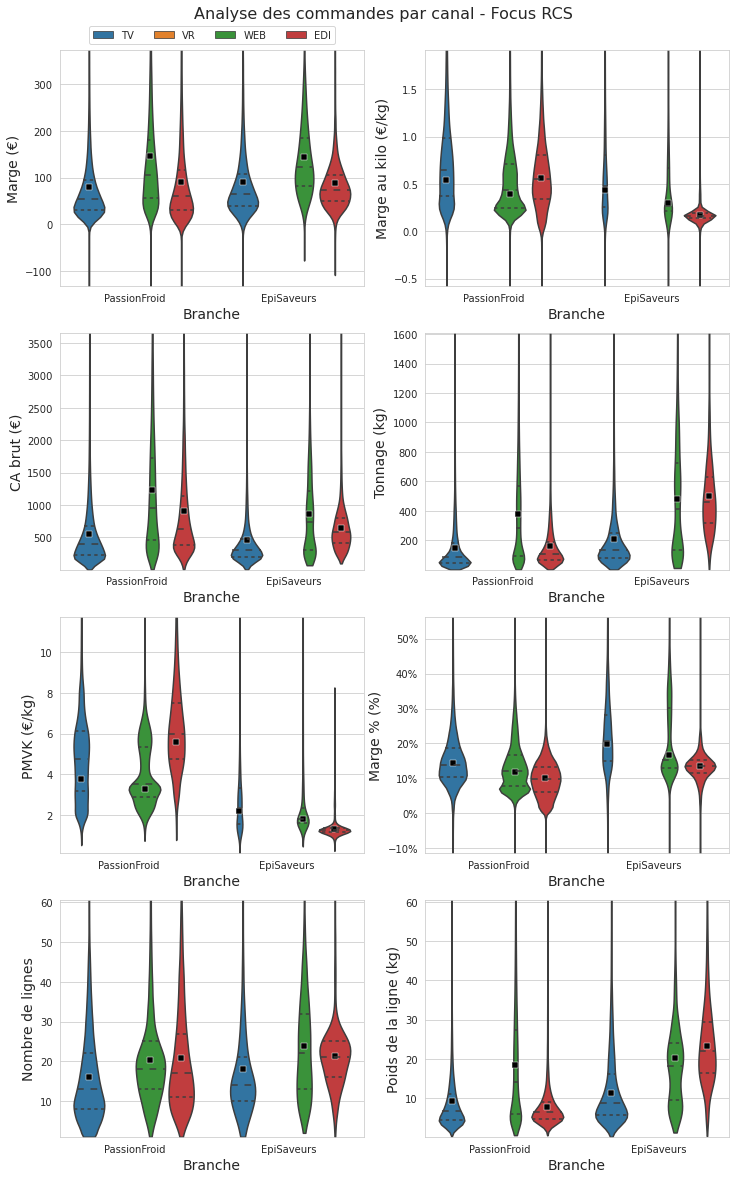

In [68]:
filter_rhd = (orders.seg1 == 'Z3')
filter_rcs = (orders.seg3 == 'ZL')

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=(filter_rcs & filter_main_origins),
                              ncols=2,
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              x='branch',
                              order=['PPF', 'PES'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='violin',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal - Focus RCS", fontsize=16, y=.91)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
#         for x in [.5, 1.5, 2.5]:
#             ax.axvline(x, lw=1, color='grey', alpha=.5)
        ax.get_legend().remove()

In [69]:
orders['otacos'] = filter_otacos.map({True: 'nonotacos', False: 'otacos'})

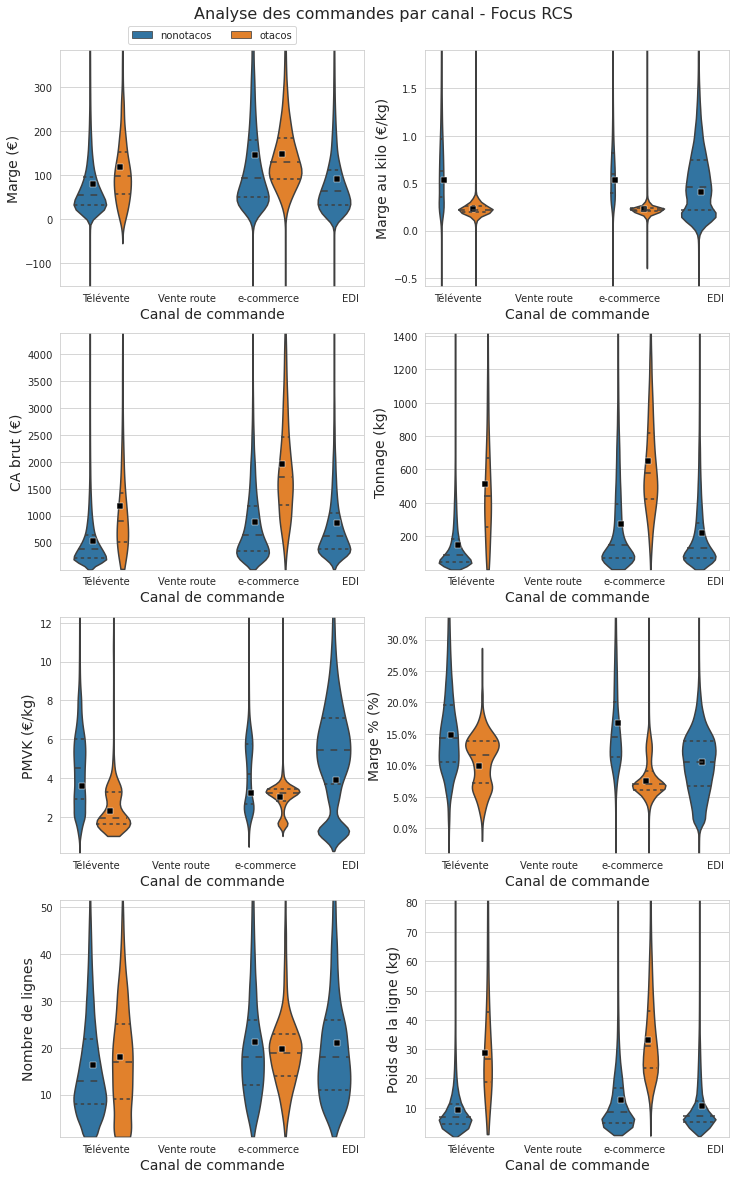

In [70]:
filter_rhd = (orders.seg1 == 'Z3')
filter_rcs = (orders.seg3 == 'ZL')

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=(filter_rcs & filter_main_origins),
                              ncols=2,
                              hue='otacos',
                              hue_order=['nonotacos', 'otacos'],
                              x='origin2',
                              order=['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='violin',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal - Focus RCS", fontsize=16, y=.91)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
#         for x in [.5, 1.5, 2.5]:
#             ax.axvline(x, lw=1, color='grey', alpha=.5)
        ax.get_legend().remove()

## Impact du Web sur les indicateurs, à la maille du client (z-score)

On calcule le zscore sur les indicateurs suivis, **à la maille du client DO**.

In [71]:
orders = pd.read_pickle(persist_path / 'small_full_orders.pkl')
orders

orgacom       date      client  margin  brutrevenue   weight  \
0          1SOU 2017-07-03  0000065940   31.16        84.01    5.501   
1          1SOU 2017-08-28  0000065940   44.36       105.93    8.048   
2          1SOU 2017-09-08  0000065940   17.60        40.35    3.000   
3          1SOU 2017-09-15  0000065940  100.12       236.77   20.312   
4          1SOU 2017-09-25  0000065940   96.04       253.99   40.338   
...         ...        ...         ...     ...          ...      ...   
2444321    2BRE 2020-08-31  0000282373  177.42      1401.58  488.036   
2444322    2BRE 2020-08-31  0000283953   43.79       421.67  564.980   
2444323    2BRE 2020-08-31  0000284089   89.39       186.75   90.200   
2444324    2BRE 2020-08-31  0000284540  262.04      1252.07  639.326   
2444325    2BRE 2020-08-31  0000284735  319.24       782.56  235.236   

         linecount origin2 seg1 seg2  ... sscat  hier4 groupecompte  \
0                9      TV   Z3   Z4  ...   Z13  10897         ZCLT   
1               10      TV   Z3   Z4  ...   Z13  10897         ZCLT   
2                2      TV   Z3   Z4  ...   Z13  10897         ZCLT   
3                3      TV   Z3   Z4  ...   Z13  10897         ZCLT   
4                5      TV   Z3   Z4  ...   Z13  10897         ZCLT   
...            ...     ...  ...  ...  ...   ...    ...          ...   
2444321         88     EDI   Z3   Z4  ...    ZA  10705         ZCRC   
2444322         28     EDI   Z3   Z4  ...   Z19  10506         ZCRC   
2444323         12      TV   Z3   Z5  ...   Z43    NaN         ZCLT   
2444324         97      TV   Z3   Z4  ...    ZA  10432         ZCRC   
2444325         58      VR   Z3   Z5  ...    ZN    NaN         ZCHN   

        relationtype pilcom       PMVK marginperkg marginpercent  lineweight  \
0                NDI    RGL  15.271769    5.664425      0.370908    0.611222   
1                NDI    RGL  13.162276    5.511928      0.418767    0.804800   
2                NDI    RGL  13.450000    5.866667      0.436183    1.500000   
3                NDI    RGL  11.656656    4.929106      0.422858    6.770667   
4                NDI    RGL   6.296544    2.380882      0.378125    8.067600   
...              ...    ...        ...         ...           ...         ...   
2444321          DIR    BIG   2.871878    0.363539      0.126586    5.545864   
2444322          DIR    NTL   0.746345    0.077507      0.103849   20.177857   
2444323          NDI    RGL   2.070399    0.991020      0.478661    7.516667   
2444324          DIR    NTL   1.958422    0.409869      0.209285    6.590990   
2444325          NDI    RGL   3.326702    1.357105      0.407943    4.055793   

         branch  
0           PPF  
1           PPF  
2           PPF  
3           PPF  
4           PPF  
...         ...  
2444321     PES  
2444322     PES  
2444323     PES  
2444324     PES  
2444325     PES  

[2444326 rows x 23 columns]

In [72]:
orders = compute_zscores(
    orders,
    grouper_fields=['orgacom', 'client'],
    indicators=indicators2,
)

margin done!
brutrevenue done!
PMVK done!
linecount done!
marginperkg done!
weight done!
marginpercent done!
lineweight done!
ALL DONE!


Redéfinition des filtres (on sait jamais...)

In [73]:
filter_otacos = (orders.hier4 != '198863')
filter_personnel = (orders.groupecompte != 'ZPER')
filter_rhd = (orders.seg1 == 'Z3')
filter_ppf = (orders.branch == 'PPF')
filter_pes = (orders.branch == 'PES')
filter_main_origins = ~(
    (orders.origin2.isin(['EDI']) & orders.seg3.isin(['ZI', 'ZK'])) |
    (orders.origin2.isin(['VR']) & orders.seg3.isin(['ZJ', 'ZL'])) |
    (orders.origin2.isin(['WEB']) & orders.seg3.isin(['ZJ']))
)
filter_2019 = (
    (orders.date >= pd.to_datetime("01-01-2019")) &
    (orders.date <= pd.to_datetime("31-12-2019"))
)
print(f"Filtrage des origines de commandes minoritaires : \n",
      f"Avant filtration il y avait {len(orders)} commandes\n",
      f"Après filtration il reste {sum(filter_main_origins)} commandes\n",
      f"Soit un delta de {len(orders) - sum(filter_main_origins)} commandes",
      f'({(len(orders) - sum(filter_main_origins)) / len(orders):.2%})',
      )

Filtrage des origines de commandes minoritaires : 
 Avant filtration il y avait 2444326 commandes
 Après filtration il reste 2428615 commandes
 Soit un delta de 15711 commandes (0.64%)


Pour un client donné, cela ne change pas le rapport entre les divers indicateurs :

In [74]:
sample = orders.reset_index().loc[orders.reset_index().origin2 == 'WEB'].sample(1).iloc[0]

0000067029 - TUTTI PIZZA AUCAMVILLE


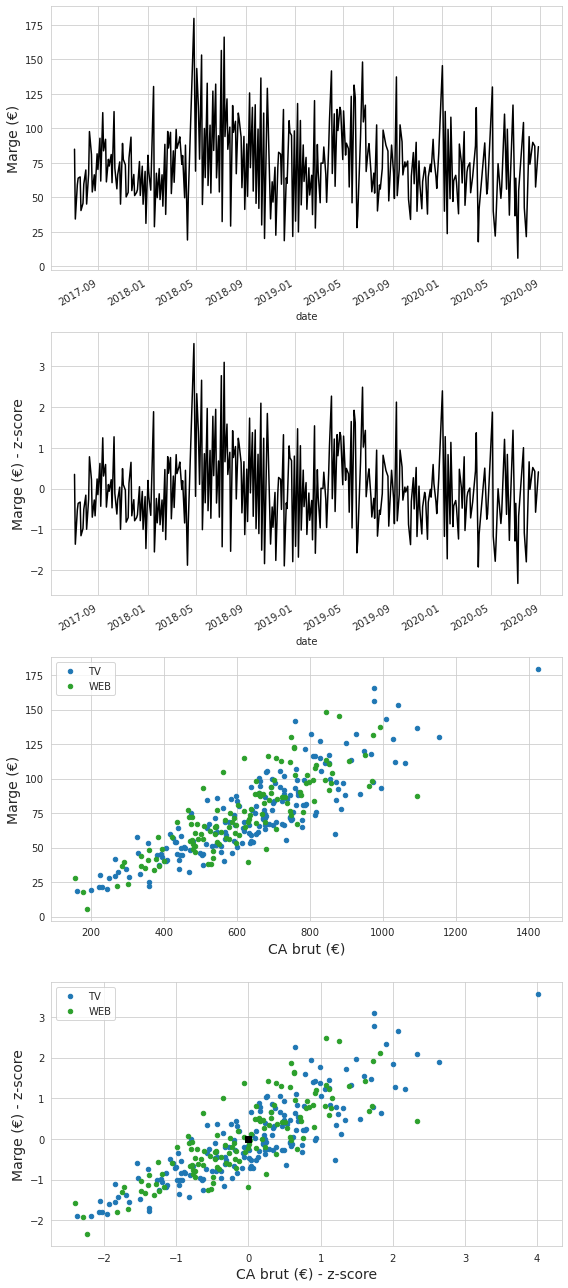

In [75]:
oc, client = '1SOU', '0000067029' #sample.orgacom, sample.client
name = df_clt.loc[(oc, client), 'nom']
print(f'{client} - {name}')
fig, axs = plt.subplots(figsize=(8, 18), nrows=4)
mask_clt = (orders.reset_index().client == client)
mask_web = mask_clt & (orders.reset_index().origin2 == 'WEB')
mask_other = mask_clt & (orders.reset_index().origin2 != 'WEB')
col_web = list(mcolor.TABLEAU_COLORS.values())[2]
col_tv = list(mcolor.TABLEAU_COLORS.values())[0]
(orders.reset_index()
       .loc[mask_other]
       .rename({'margin': 'Marge (€)',
                'brutrevenue': 'CA brut (€)'}, axis=1)
       .plot(kind='scatter', y='Marge (€)', x='CA brut (€)', color=col_tv, ax=axs[2], label='TV')
)
(orders.reset_index()
       .loc[mask_web]
       .rename({'margin': 'Marge (€)',
                'brutrevenue': 'CA brut (€)'}, axis=1)
       .plot(kind='scatter', y='Marge (€)', x='CA brut (€)', color=col_web, ax=axs[2], label='WEB')
)

(orders.reset_index()
       .loc[mask_other]
       .rename({'margin_clt_zscore': 'Marge (€) - z-score',
                'brutrevenue_clt_zscore': 'CA brut (€) - z-score'}, axis=1)
       .plot(kind='scatter', y='Marge (€) - z-score', x='CA brut (€) - z-score', color=col_tv, ax=axs[3], label='TV')
)
(orders.reset_index()
       .loc[mask_web]
       .rename({'margin_clt_zscore': 'Marge (€) - z-score',
                'brutrevenue_clt_zscore': 'CA brut (€) - z-score'}, axis=1)
       .plot(kind='scatter', y='Marge (€) - z-score', x='CA brut (€) - z-score', color=col_web, ax=axs[3], label='WEB')
)

axs[3].scatter(x=[0], y=[0], marker='s', color='black')
orders.reset_index().loc[mask_clt].plot(kind='line', y='margin', x='date', color='black', ax=axs[0])
orders.reset_index().loc[mask_clt].plot(kind='line', y='margin_clt_zscore', x='date', color='black', ax=axs[1])
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[0].set_ylabel('Marge (€)', fontsize=14)
axs[1].set_ylabel('Marge (€) - z-score', fontsize=14)
axs[2].set_ylabel('Marge (€)', fontsize=14)
axs[3].set_ylabel('Marge (€) - z-score', fontsize=14)
axs[2].set_xlabel('CA brut (€)', fontsize=14)
axs[3].set_xlabel('CA brut (€) - z-score', fontsize=14)
axs[2].legend()
axs[3].legend()
fig.tight_layout()

### Création d'un exemple fictif

On crée un exemple fictif pour illustrer.

In [76]:
def dt_linspace(start, end, n):
    start = pd.Timestamp(start)
    end = pd.Timestamp(end)
    t = np.linspace(start.value, end.value, n)
    t = pd.to_datetime(t)
    return(t)
t1 = dt_linspace('2019-01-01', '2019-03-31', 10)
type(t1)

pandas.core.indexes.datetimes.DatetimeIndex

In [77]:
palette = [
    list(mcolor.TABLEAU_COLORS.values())[0],
    list(mcolor.TABLEAU_COLORS.values())[2],
]

len_clt1 = 50
clt1_origin = ['TV'] * len_clt1
web_clt1_indices = [12, 36]
for idx_ in web_clt1_indices:
    clt1_origin[idx_] = 'WEB'


ex_df = [
    pd.DataFrame(
        {
            'client': ['clt1'] * len_clt1,
            'date': dt_linspace('2019-01-01', '2019-03-31',len_clt1),
            'origin': clt1_origin,
            'margin': np.random.normal(size=len_clt1) + [10] * len_clt1,
        }
    ),
    pd.DataFrame(
        {
            'client': ['clt2'] * 15,
            'date': dt_linspace('2019-01-01', '2019-03-22', 15),
            'origin': ['TV'] * 7 + ['WEB'] * 8,
            'margin': np.random.normal(size=15) + ([25] * 7 + [20] * 8),
        }
    )
]
ex_df = pd.concat(ex_df)
ex_df = utils.compute_zscores(ex_df, indicators=['margin'], grouper_fields=['client'])
# sns.scatterplot(data=ex_df, x='date', y='margin', hue=ex_df.origin.to_list(),
#                 palette=palette,
#                 style=ex_df.origin.to_list(),
#                )

margin done!
ALL DONE!


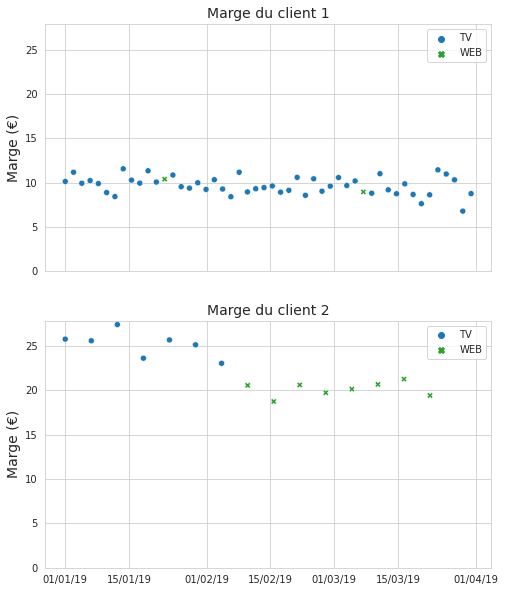

In [78]:
fig, axs = plt.subplots(nrows=2, figsize=(8,10), sharex=True)
to_plot = ex_df.loc[ex_df.client == 'clt1']
sns.scatterplot(data=to_plot,
                x='date',
                y='margin',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=axs[0],
               )
to_plot = ex_df.loc[ex_df.client == 'clt2']
sns.scatterplot(data=to_plot,
                x='date',
                y='margin',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=axs[1],
               )
axs[1].set_ylim(0)
axs[0].set_ylim(0, axs[1].get_ylim()[1])
axs[0].set_title('Marge du client 1', fontsize=14)
axs[1].set_title('Marge du client 2', fontsize=14)
axs[1].set_xlabel(None)
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y"))
for ax in axs:
    ax.set_ylabel('Marge (€)', fontsize=14)

Text(0, 0.5, 'Marge (€)')

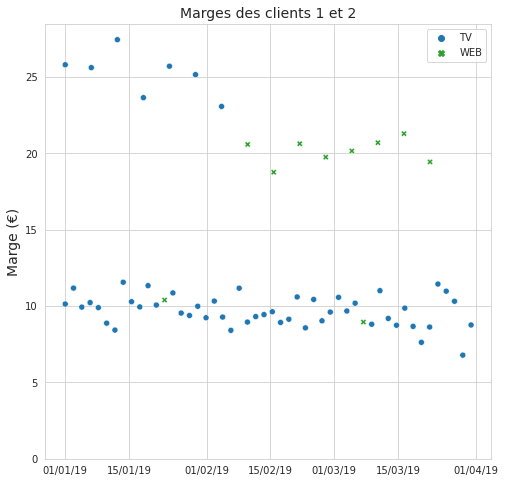

In [79]:
fig, ax = plt.subplots(figsize=(8, 8))
to_plot = ex_df
sns.scatterplot(data=to_plot,
                x='date',
                y='margin',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=ax,
               )
ax.set_title('Marges des clients 1 et 2', fontsize=14)
ax.set_xlabel(None)
ax.set_ylim(0)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y"))
ax.set_ylabel('Marge (€)', fontsize=14)

In [80]:
utils.plot_distrib?

<AxesSubplot:xlabel='Canal de commande', ylabel='Marge (€) - z-score'>

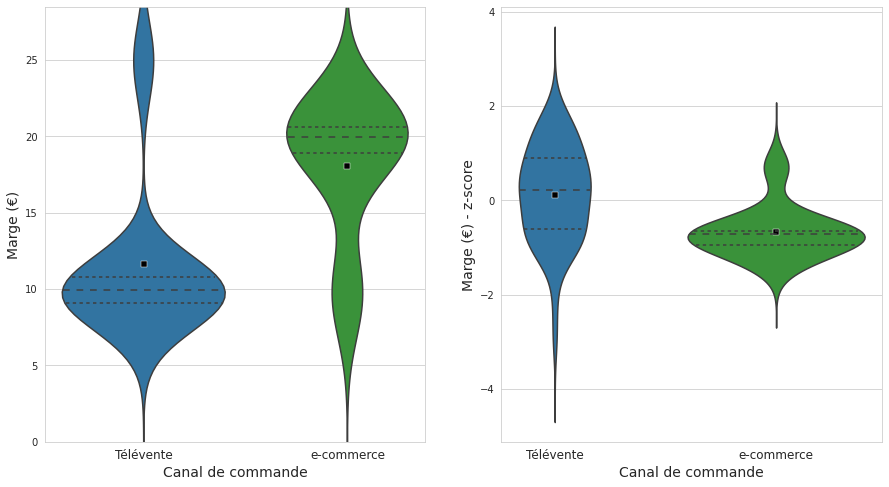

In [81]:
fig, axs = utils.plot_distrib(
    data=ex_df, 
    ncols=2,
    indicators=['margin', 'margin_clt_zscore'],
    x='origin',
    order=['TV', 'WEB'],
    kind='violin',
    percentile_selection=0.99,
    IQR_factor_selection=3.0,
    IQR_factor_plot=None,
    show_means=True,
    plot_kwargs=dict(palette=palette, cut=4.),
    translate=['x', 'indicator', 'xaxis'],
    fontsizes_kwargs=None,    
)
axs[0, 0].set_ylim(0, ax.get_ylim()[1])
axs[0, 1]

In [82]:
utils.pretty_means(data=ex_df,
                   groupers=['origin'],
                   indicators=['margin', 'margin_clt_zscore'],
                   translate=['columns', 'origin']
                  )

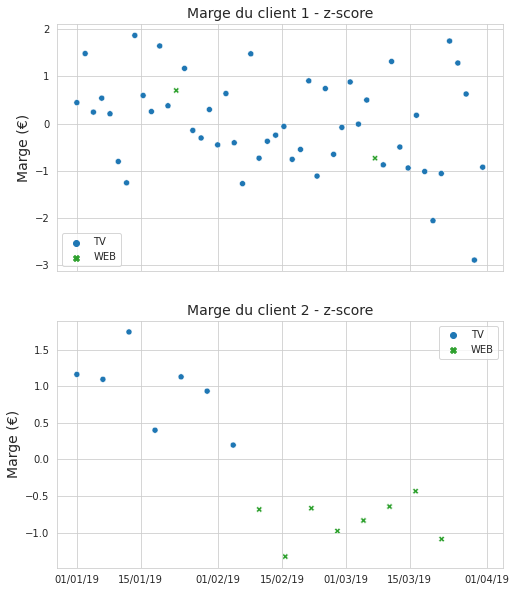

In [83]:
fig, axs = plt.subplots(nrows=2, figsize=(8,10), sharex=True)
to_plot = ex_df.loc[ex_df.client == 'clt1']
sns.scatterplot(data=to_plot,
                x='date',
                y='margin_clt_zscore',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=axs[0],
               )
to_plot = ex_df.loc[ex_df.client == 'clt2']
sns.scatterplot(data=to_plot,
                x='date',
                y='margin_clt_zscore',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=axs[1],
               )
axs[0].set_title('Marge du client 1 - z-score', fontsize=14)
axs[1].set_title('Marge du client 2 - z-score', fontsize=14)
axs[1].set_xlabel(None)
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y"))
for ax in axs:
    ax.set_ylabel('Marge (€)', fontsize=14)

Text(0, 0.5, 'Marge (€) - z-score')

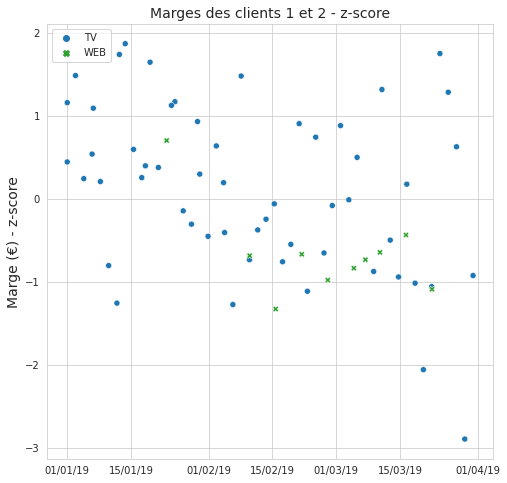

In [84]:
fig, ax = plt.subplots(figsize=(8, 8))
to_plot = ex_df
sns.scatterplot(data=to_plot,
                x='date',
                y='margin_clt_zscore',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=ax,
               )
ax.set_title('Marges des clients 1 et 2 - z-score', fontsize=14)
ax.set_xlabel(None)
# ax.set_ylim(0)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y"))
ax.set_ylabel('Marge (€) - z-score', fontsize=14)

## Affichage des indicateurs en zscore par canal

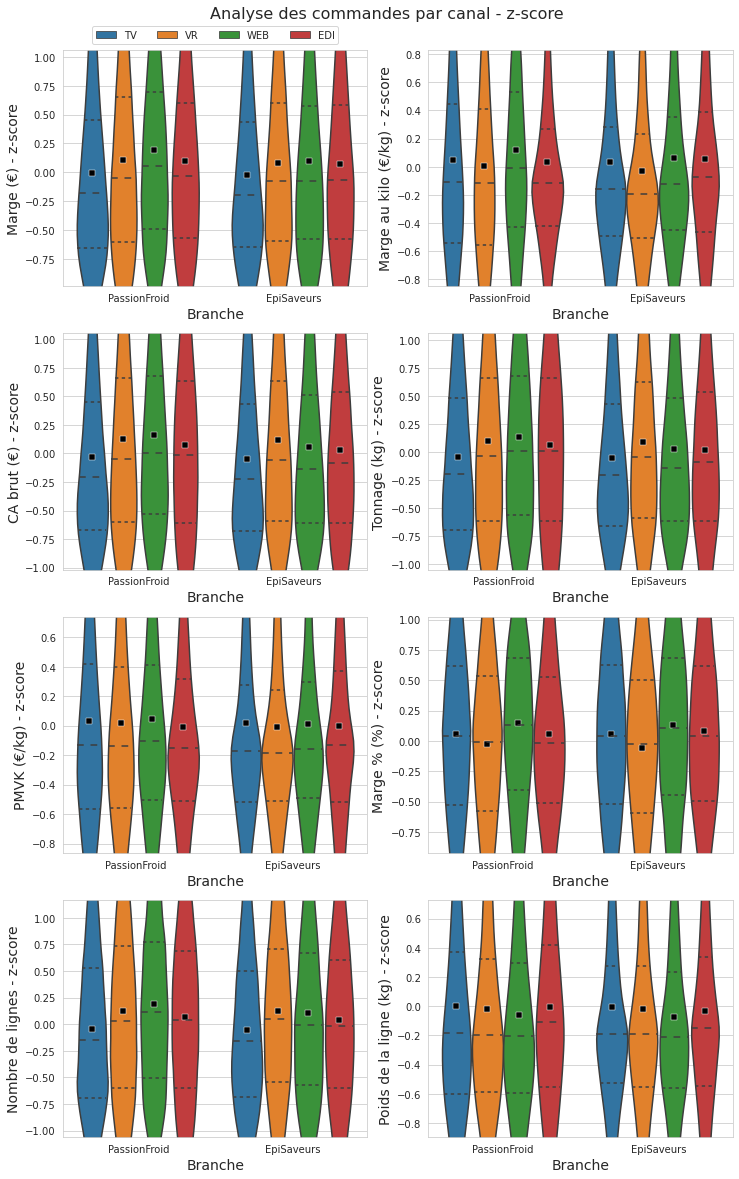

In [86]:
indicators_zscore = [indicator + '_clt_zscore' for indicator in indicators2]

filters = filter_2019
filters_means = filter_2019

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=filters,
                              ncols=2,
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              x='branch',
                              order=['PPF', 'PES'],
                              translate=['xaxis', 'indicator', 'x', ],
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=.3,
                              show_means=True,
                              plot_kwargs=dict(whis=1.5),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal - z-score", fontsize=16, y=.91)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
#         for x in [.5, 1.5, 2.5]:
#             ax.axvline(x, lw=1, color='grey', alpha=.5)
        ax.get_legend().remove()

utils.pretty_means(data=orders.reset_index().loc[filters_means],
                   groupers=['branch', 'origin2'],
                   indicators=indicators_zscore,
                   translate=['columns', 'origin2', 'branch']
                  )

## Affichage des indicateurs en zscore par canal et succursale

/homedm/pmasse/WebOrNot/scripts/utils.py:640: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


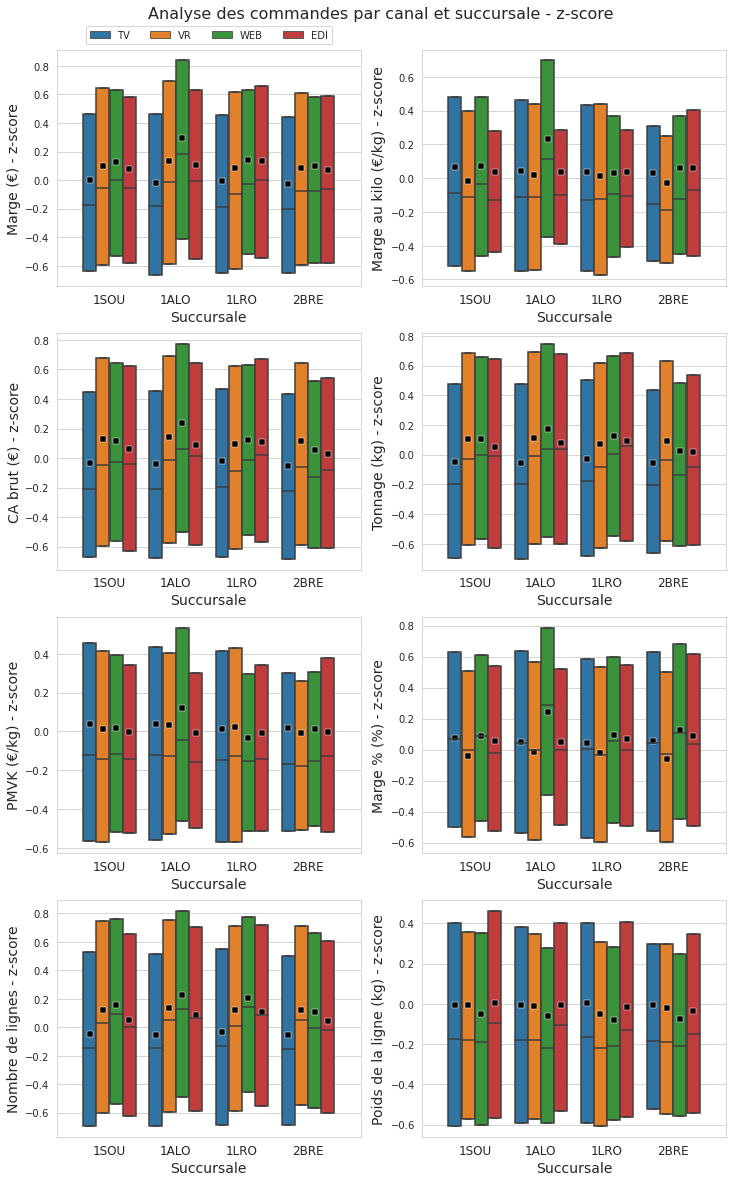

In [87]:

filters = filter_2019
filters_means = filter_2019

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=filters,
                              ncols=2,
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              hue='origin2',
                              hue_order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', ],
                              kind='boxplot',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
#                               IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal et succursale - z-score", fontsize=16, y=.91)
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )

utils.pretty_means(data=orders.reset_index().loc[filters_means],
                   groupers=['orgacom', 'origin2'],
                   indicators=indicators_zscore,
                   translate=['columns', 'origin2']
                  )

## Affichage des indicateurs en zscore par canal et par segment - PassionFroid

In [88]:
orders

orgacom       date      client  margin  brutrevenue   weight  \
0          1SOU 2017-07-03  0000065940   31.16        84.01    5.501   
1          1SOU 2017-08-28  0000065940   44.36       105.93    8.048   
2          1SOU 2017-09-08  0000065940   17.60        40.35    3.000   
3          1SOU 2017-09-15  0000065940  100.12       236.77   20.312   
4          1SOU 2017-09-25  0000065940   96.04       253.99   40.338   
...         ...        ...         ...     ...          ...      ...   
2444321    2BRE 2020-08-31  0000282373  177.42      1401.58  488.036   
2444322    2BRE 2020-08-31  0000283953   43.79       421.67  564.980   
2444323    2BRE 2020-08-31  0000284089   89.39       186.75   90.200   
2444324    2BRE 2020-08-31  0000284540  262.04      1252.07  639.326   
2444325    2BRE 2020-08-31  0000284735  319.24       782.56  235.236   

         linecount origin2 seg1 seg2  ... lineweight branch margin_clt_zscore  \
0                9      TV   Z3   Z4  ...   0.611222    PPF         -0.515855   
1               10      TV   Z3   Z4  ...   0.804800    PPF         -0.423595   
2                2      TV   Z3   Z4  ...   1.500000    PPF         -0.610631   
3                3      TV   Z3   Z4  ...   6.770667    PPF         -0.033868   
4                5      TV   Z3   Z4  ...   8.067600    PPF         -0.062385   
...            ...     ...  ...  ...  ...        ...    ...               ...   
2444321         88     EDI   Z3   Z4  ...   5.545864    PES          0.000000   
2444322         28     EDI   Z3   Z4  ...  20.177857    PES          0.000000   
2444323         12      TV   Z3   Z5  ...   7.516667    PES          0.000000   
2444324         97      TV   Z3   Z4  ...   6.590990    PES          0.000000   
2444325         58      VR   Z3   Z5  ...   4.055793    PES          0.000000   

        brutrevenue_clt_zscore PMVK_clt_zscore linecount_clt_zscore  \
0                    -0.420589        0.842437             2.795673   
1                    -0.376466        0.423512             3.252761   
2                    -0.508474        0.480651            -0.403938   
3                    -0.113095        0.124511             0.053150   
4                    -0.078432       -0.939954             0.967324   
...                        ...             ...                  ...   
2444321               0.000000        0.000000             0.000000   
2444322               0.000000        0.000000             0.000000   
2444323               0.000000        0.000000             0.000000   
2444324               0.000000        0.000000             0.000000   
2444325               0.000000        0.000000             0.000000   

        marginperkg_clt_zscore weight_clt_zscore  marginpercent_clt_zscore  \
0                     0.466740         -0.530799                 -0.278684   
1                     0.405407         -0.480297                  0.158020   
2                     0.548080         -0.580390                  0.316941   
3                     0.171000         -0.237125                  0.195346   
4                    -0.853875          0.159954                 -0.212831   
...                        ...               ...                       ...   
2444321               0.000000          0.000000                  0.000000   
2444322               0.000000          0.000000                  0.000000   
2444323               0.000000          0.000000                  0.000000   
2444324               0.000000          0.000000                  0.000000   
2444325               0.000000          0.000000                  0.000000   

         lineweight_clt_zscore  
0                    -0.939472  
1                    -0.922003  
2                    -0.859268  
3                    -0.383636  
4                    -0.266600  
...                        ...  
2444321               0.000000  
2444322               0.000000  
2444323               0.000000  
2444324               0.000000  
2444325          

/homedm/pmasse/WebOrNot/scripts/utils.py:640: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


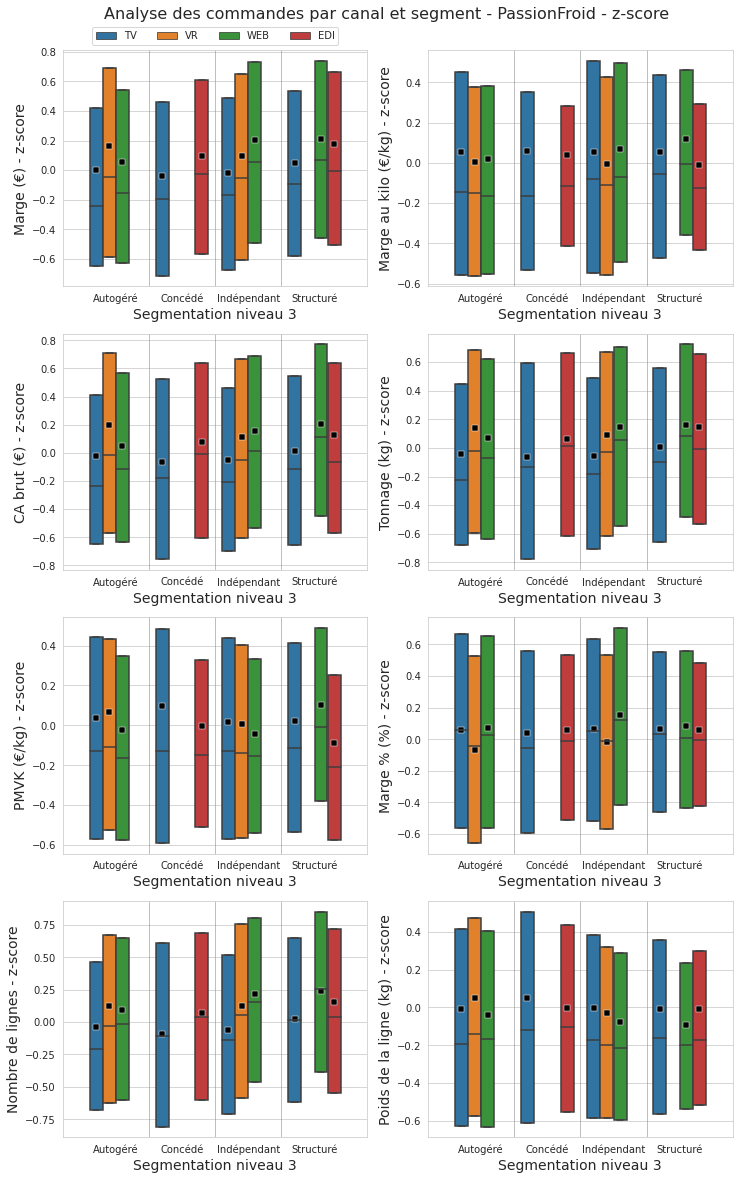

In [89]:
filters = filter_main_origins & filter_ppf & filter_rhd & filter_2019
filters_means = filter_rhd & filter_ppf & filter_main_origins & filter_2019

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=filters,
                              ncols=2,
                              x='seg3',
                              order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              hue='origin2',
                              hue_order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='boxplot',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
#                               IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal et segment - PassionFroid - z-score", fontsize=16, y=.91)
for ax_list in axs:
    for ax in ax_list:
        for x in [.5, 1.5, 2.5]:
            ax.axvline(x, lw=1, color='grey', alpha=.5)        
        ax.get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
        
    
utils.pretty_means(data=orders.loc[filters_means].reset_index(),
                   groupers=['seg3', 'origin2'],
                   indicators=indicators_zscore,
                   translate=['columns', 'seg3', 'origin2']
                  )

## Affichage des indicateurs en zscore par canal et par segment - PassionFroid

/homedm/pmasse/WebOrNot/scripts/utils.py:640: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


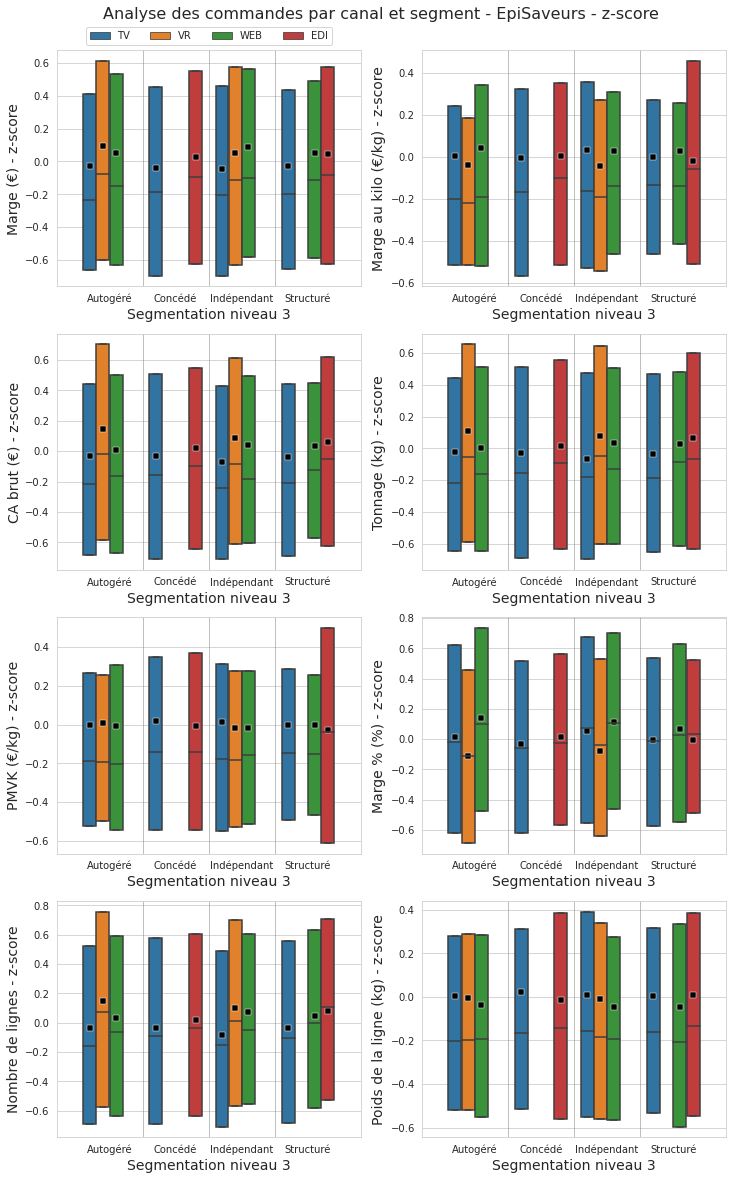

In [90]:
filters = filter_main_origins & filter_pes
filters_means = filter_rhd & filter_pes

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=filters,
                              ncols=2,
                              x='seg3',
                              order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              hue='origin2',
                              hue_order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='boxplot',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
#                               IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal et segment - EpiSaveurs - z-score", fontsize=16, y=.91)
for ax_list in axs:
    for ax in ax_list:
        for x in [.5, 1.5, 2.5]:
            ax.axvline(x, lw=1, color='grey', alpha=.5)        
        ax.get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
        
    
utils.pretty_means(data=orders.loc[filters_means].reset_index(),
                   groupers=['seg3', 'origin2'],
                   indicators=indicators_zscore,
                   translate=['columns', 'seg3', 'origin2']
                  )

## Analyse comportementale, première modélisation : bascule à la première commande Web

Dans un premier temps, on va considérer que la bascule se fait à la première commande Web. Les hypothèses sont : 
- le statut est initialement le canal de la première commande
- ensuite, il est 'WEB' à partir de la première commande web

On commence par calculer le statut initial de chaque client

In [102]:
try:
    first_order = (
        orders.groupby(['orgacom', 'client'], observed=True)['date']
              .min()
              .reset_index()
        )
except KeyError: 
    orders = orders.reset_index()
    first_order = (
        orders.groupby(['orgacom', 'client'], observed=True)['date']
              .min()
              .reset_index()
        )    

On initialise la table des mises à jour de statuts :

In [103]:
status_updates = (
    orders[['orgacom',
            'client',
            'date',
            'origin2']].merge(first_order,
                              on=['orgacom', 'client', 'date'],
                              how='inner',
                              validate='1:1')
                       .rename({'origin2': 'new_stat'}, axis=1)
                       .set_index(['orgacom', 'client', 'date'])
)

On complète en ajoutant la première commande WEB (si elle n'est pas également la première commande).

In [104]:
status_updates2 = (
orders.loc[orders.origin2 == 'WEB']
      .groupby(['client', 'orgacom'], observed=True)['date']
      .min()
      .reset_index()
      .set_index(['orgacom', 'client', 'date'])
)
status_updates2['new_stat'] = 'WEB'
status_updates = (status_updates.append(status_updates2.loc[~status_updates2.index.isin(status_updates.index)])
                                .sort_values(['orgacom', 'client', 'date'])
                 )
status_updates = status_updates.sort_index()
del(status_updates2)
if len(status_updates.loc[status_updates.index.duplicated(keep=False)]) > 0.:
    raise RuntimeError('Something went wrong in computing statuses!')

In [105]:
status_updates

new_stat
orgacom client     date               
1ALO    0000015304 2017-07-03       TV
        0000015982 2018-03-20       TV
        0000016309 2017-07-03       VR
        0000018297 2017-07-03      EDI
        0000018298 2017-07-10      EDI
...                                ...
2BRE    SL008B     2017-12-01       TV
        SL008C     2017-07-11       TV
        SL008R     2017-07-28       TV
        SL009N     2017-07-04       TV
        SLD008B    2018-09-14       TV

[37000 rows x 1 columns]

On rappatrie le statut calculé depuis la tables des mises à jour de statut (`status_updates`) dans la table des commandes (`orders`).

In [106]:
statuses = (
    status_updates.reindex(status_updates.index.union(orders.set_index(['orgacom', 'client', 'date']).index))
                  .sort_index()
                  .fillna(method='ffill')
                  .rename({'new_stat': 'clt_stat'}, axis=1)
)

try:
    del(orders['clt_stat'])
except KeyError:
    pass       

orders2 = (
orders.set_index(['orgacom', 'client', 'date'])
      .merge(statuses, left_index=True, right_index=True, how='left', indicator=True, validate='1:1')
) 
    
if len(orders2.loc[orders2._merge != 'both']) > 0: 
    raise RuntimeError('Something went wrong during statuses computation')
if len(orders2) != len(orders):
    raise RuntimeError('Something went wrong during statuses computation')
orders = orders2
del(statuses)
del(orders['_merge'])

In [107]:
orders.sample(5)

margin  brutrevenue   weight  linecount  \
orgacom client     date                                                  
1ALO    0000259605 2020-06-11  129.33       647.98  109.080         14   
2BRE    0000073719 2019-09-20  150.12       530.87  190.675         23   
1SOU    0000066661 2018-03-22  412.41      1160.43  126.015          3   
        0000231794 2019-10-17   69.88       407.41  138.400         14   
        0000125086 2019-01-09   37.28       419.37  108.000          7   

                              origin2 seg1 seg2 seg3 seg4 cat  ... branch  \
orgacom client     date                                        ...          
1ALO    0000259605 2020-06-11      TV   Z4   Z7   ZM   ZK  Z1  ...    PPF   
2BRE    0000073719 2019-09-20      TV   Z3   Z5   ZK   ZG  ZU  ...    PES   
1SOU    0000066661 2018-03-22      VR   Z3   Z4   ZI   ZB  ZL  ...    PPF   
        0000231794 2019-10-17      TV   Z3   Z4   ZJ   ZF  ZM  ...    PPF   
        0000125086 2019-01-09     EDI   Z3   Z4   ZJ   ZF  ZP  ...    PPF   

                              margin_clt_zscore brutrevenue_clt_zscore  \
orgacom client     date                                                  
1ALO    0000259605 2020-06-11          0.200666               0.682855   
2BRE    0000073719 2019-09-20          1.292547               0.899832   
1SOU    0000066661 2018-03-22          0.570998               0.422674   
        0000231794 2019-10-17          0.581632               0.563192   
        0000125086 2019-01-09         -0.797573              -0.756391   

                              PMVK_clt_zscore linecount_clt_zscore  \
orgacom client     date                                              
1ALO    0000259605 2020-06-11        0.707648             0.622314   
2BRE    0000073719 2019-09-20        0.054320             0.308969   
1SOU    0000066661 2018-03-22        0.117275             0.000000   
        0000231794 2019-10-17       -0.104056             0.587800   
        0000125086 2019-01-09        0.468905            -1.199000   

                               marginperkg_clt_zscore  weight_clt_zscore  \
orgacom client     date                                                    
1ALO    0000259605 2020-06-11                0.056995           0.256151   
2BRE    0000073719 2019-09-20                0.618648           0.559681   
1SOU    0000066661 2018-03-22               -0.066183           0.168162   
        0000231794 2019-10-17               -0.122047           0.662869   
        0000125086 2019-01-09                0.008600          -1.118144   

                               marginpercent_clt_zscore  \
orgacom client     date                                   
1ALO    0000259605 2020-06-11                 -0.001935   
2BRE    0000073719 2019-09-20                  0.595551   
1SOU    0000066661 2018-03-22                 -0.260249   
        0000231794 2019-10-17                 -0.145343   
        0000125086 2019-01-09                 -0.399956   

                               lineweight_clt_zscore clt_stat  
orgacom client     date                                        
1ALO    0000259605 2020-06-11              -0.091971       TV  
2BRE    0000073719 2019-09-20               0.182663      WEB  
1SOU    0000066661 2018-03-22               0.035501       TV  
        0000231794 2019-10-17               0.279337       TV  
        0000125086 2019-01-09              -0.046330      EDI  

[5 rows x 29 columns]

On rappatrie ensuite de quoi calculer les indicateurs dans la table des mises à jour de statut.

In [108]:
(
orders.groupby(['orgacom', 'client', 'clt_stat'], observed=True)
      .agg({'margin': 'sum',
            'brutrevenue': 'sum', 
            'weight': 'sum', 
            'linecount': 'sum', 
            'origin2': 'size',
           })
      .rename({'origin2': 'ordercount'}, axis=1)
)

margin  brutrevenue     weight  linecount  \
orgacom client     clt_stat                                                
1ALO    0000015304 TV        55658.86    490584.24  75378.032       2158   
        0000015982 TV          365.56       680.31    138.864         25   
        0000016309 VR        35426.83     82901.05  15209.370       1304   
        0000018297 EDI       13445.05    162991.61  46191.109       6495   
        0000018298 EDI        3004.76     42922.74  11793.510       2437   
...                               ...          ...        ...        ...   
2BRE    SL008B     TV          190.97      4398.58   3303.984          2   
        SL008C     TV         7578.42     71848.30  21946.816        367   
        SL008R     TV          263.63      6992.88   2009.948         43   
        SL009N     TV         5107.84     14556.72   4057.578        172   
        SLD008B    TV            3.82        70.05      4.400          1   

                             ordercount  
orgacom client     clt_stat              
1ALO    0000015304 TV               639  
        0000015982 TV                 1  
        0000016309 VR               109  
        0000018297 EDI              207  
        0000018298 EDI              139  
...                                 ...  
2BRE    SL008B     TV                 2  
        SL008C     TV                95  
        SL008R     TV                25  
        SL009N     TV                48  
        SLD008B    TV                 1  

[37000 rows x 5 columns]

In [109]:
status_updates = status_updates.reset_index().set_index(['orgacom', 'client', 'new_stat']).join(
    orders.rename({'clt_stat': 'new_stat'}, axis=1)
          .groupby(['orgacom', 'client', 'new_stat'], observed=True)
          .agg({'margin': 'sum',
                'brutrevenue': 'sum', 
                'weight': 'sum', 
                'linecount': 'sum', 
                'origin2': 'size',
               })
          .rename({'origin2': 'ordercount'}, axis=1)         
)
status_updates

date    margin  brutrevenue     weight  \
orgacom client     new_stat                                                
1ALO    0000015304 TV       2017-07-03  55658.86    490584.24  75378.032   
        0000015982 TV       2018-03-20    365.56       680.31    138.864   
        0000016309 VR       2017-07-03  35426.83     82901.05  15209.370   
        0000018297 EDI      2017-07-03  13445.05    162991.61  46191.109   
        0000018298 EDI      2017-07-10   3004.76     42922.74  11793.510   
...                                ...       ...          ...        ...   
2BRE    SL008B     TV       2017-12-01    190.97      4398.58   3303.984   
        SL008C     TV       2017-07-11   7578.42     71848.30  21946.816   
        SL008R     TV       2017-07-28    263.63      6992.88   2009.948   
        SL009N     TV       2017-07-04   5107.84     14556.72   4057.578   
        SLD008B    TV       2018-09-14      3.82        70.05      4.400   

                             linecount  ordercount  
orgacom client     new_stat                         
1ALO    0000015304 TV             2158         639  
        0000015982 TV               25           1  
        0000016309 VR             1304         109  
        0000018297 EDI            6495         207  
        0000018298 EDI            2437         139  
...                                ...         ...  
2BRE    SL008B     TV                2           2  
        SL008C     TV              367          95  
        SL008R     TV               43          25  
        SL009N     TV              172          48  
        SLD008B    TV                1           1  

[37000 rows x 6 columns]

In [110]:
status_updates['PMVK'] = status_updates.brutrevenue / status_updates.weight
status_updates['marginperkg'] = status_updates.margin / status_updates.weight
status_updates['marginpercent'] = status_updates.margin / status_updates.brutrevenue
status_updates['lineweight'] = status_updates.weight / status_updates.linecount
for indicator in ['margin', 'brutrevenue', 'weight', 'linecount']:
    status_updates[indicator] /= status_updates['ordercount']
status_updates = status_updates.reset_index().set_index(['orgacom', 'client', 'date'])
status_updates

new_stat      margin  brutrevenue       weight  \
orgacom client     date                                                        
1ALO    0000015304 2017-07-03       TV   87.103067   767.737465   117.962491   
        0000015982 2018-03-20       TV  365.560000   680.310000   138.864000   
        0000016309 2017-07-03       VR  325.016789   760.560092   139.535505   
        0000018297 2017-07-03      EDI   64.951932   787.399082   223.145454   
        0000018298 2017-07-10      EDI   21.616978   308.796691    84.845396   
...                                ...         ...          ...          ...   
2BRE    SL008B     2017-12-01       TV   95.485000  2199.290000  1651.992000   
        SL008C     2017-07-11       TV   79.772842   756.297895   231.019116   
        SL008R     2017-07-28       TV   10.545200   279.715200    80.397920   
        SL009N     2017-07-04       TV  106.413333   303.265000    84.532875   
        SLD008B    2018-09-14       TV    3.820000    70.050000     4.400000   

                               linecount  ordercount       PMVK  marginperkg  \
orgacom client     date                                                        
1ALO    0000015304 2017-07-03   3.377152         639   6.508318     0.738396   
        0000015982 2018-03-20  25.000000           1   4.899110     2.632504   
        0000016309 2017-07-03  11.963303         109   5.450656     2.329277   
        0000018297 2017-07-03  31.376812         207   3.528636     0.291074   
        0000018298 2017-07-10  17.532374         139   3.639522     0.254781   
...                                  ...         ...        ...          ...   
2BRE    SL008B     2017-12-01   1.000000           2   1.331296     0.057800   
        SL008C     2017-07-11   3.863158          95   3.273746     0.345308   
        SL008R     2017-07-28   1.720000          25   3.479135     0.131163   
        SL009N     2017-07-04   3.583333          48   3.587539     1.258840   
        SLD008B    2018-09-14   1.000000           1  15.920455     0.868182   

                               marginpercent   lineweight  
orgacom client     date                                    
1ALO    0000015304 2017-07-03       0.113454    34.929579  
        0000015982 2018-03-20       0.537343     5.554560  
        0000016309 2017-07-03       0.427339    11.663627  
        0000018297 2017-07-03       0.082489     7.111795  
        0000018298 2017-07-10       0.070004     4.839356  
...                                      ...          ...  
2BRE    SL008B     2017-12-01       0.043416  1651.992000  
        SL008C     2017-07-11       0.105478    59.800589  
        SL008R     2017-07-28       0.037700    46.742977  
        SL009N     2017-07-04       0.350892    23.590570  
        SLD008B    2018-09-14       0.054532     4.400000  

[37000 rows x 10 columns]

In [111]:
orders

margin  brutrevenue   weight  linecount  \
orgacom client     date                                                  
1SOU    0000065940 2017-07-03   31.16        84.01    5.501          9   
                   2017-08-28   44.36       105.93    8.048         10   
                   2017-09-08   17.60        40.35    3.000          2   
                   2017-09-15  100.12       236.77   20.312          3   
                   2017-09-25   96.04       253.99   40.338          5   
...                               ...          ...      ...        ...   
2BRE    0000282373 2020-08-31  177.42      1401.58  488.036         88   
        0000283953 2020-08-31   43.79       421.67  564.980         28   
        0000284089 2020-08-31   89.39       186.75   90.200         12   
        0000284540 2020-08-31  262.04      1252.07  639.326         97   
        0000284735 2020-08-31  319.24       782.56  235.236         58   

                              origin2 seg1 seg2 seg3 seg4 cat  ... branch  \
orgacom client     date                                        ...          
1SOU    0000065940 2017-07-03      TV   Z3   Z4   ZI   ZB  ZL  ...    PPF   
                   2017-08-28      TV   Z3   Z4   ZI   ZB  ZL  ...    PPF   
                   2017-09-08      TV   Z3   Z4   ZI   ZB  ZL  ...    PPF   
                   2017-09-15      TV   Z3   Z4   ZI   ZB  ZL  ...    PPF   
                   2017-09-25      TV   Z3   Z4   ZI   ZB  ZL  ...    PPF   
...                               ...  ...  ...  ...  ...  ..  ...    ...   
2BRE    0000282373 2020-08-31     EDI   Z3   Z4   ZJ   ZF  ZP  ...    PES   
        0000283953 2020-08-31     EDI   Z3   Z4   ZJ   ZF  ZN  ...    PES   
        0000284089 2020-08-31      TV   Z3   Z5   ZK   ZG  ZU  ...    PES   
        0000284540 2020-08-31      TV   Z3   Z4   ZJ   ZF  ZP  ...    PES   
        0000284735 2020-08-31      VR   Z3   Z5   ZK   ZG  ZU  ...    PES   

                              margin_clt_zscore brutrevenue_clt_zscore  \
orgacom client     date                                                  
1SOU    0000065940 2017-07-03         -0.515855              -0.420589   
                   2017-08-28         -0.423595              -0.376466   
                   2017-09-08         -0.610631              -0.508474   
                   2017-09-15         -0.033868              -0.113095   
                   2017-09-25         -0.062385              -0.078432   
...                                         ...                    ...   
2BRE    0000282373 2020-08-31          0.000000               0.000000   
        0000283953 2020-08-31          0.000000               0.000000   
        0000284089 2020-08-31          0.000000               0.000000   
        0000284540 2020-08-31          0.000000               0.000000   
        0000284735 2020-08-31          0.000000               0.000000   

                              PMVK_clt_zscore linecount_clt_zscore  \
orgacom client     date                                              
1SOU    0000065940 2017-07-03        0.842437             2.795673   
                   2017-08-28        0.423512             3.252761   
                   2017-09-08        0.480651            -0.403938   
                   2017-09-15        0.124511             0.053150   
                   2017-09-25       -0.939954             0.967324   
...                                       ...                  ...   
2BRE    0000282373 2020-08-31        0.000000             0.000000   
        0000283953 2020-08-31        0.000000             0.000000   
        0000284089 2020-08-31        0.000000             0.000000   
        0000284540 2020-08-31        0.000000             0.000000   
        0000284735 2020-08-31        0.000000             0.000000   

                               marginperkg_clt_zscore  weight_clt_zscore  \
orgacom client     date                                                    
1SOU    0000065940 2017-07-03           

In [112]:
status_updates = compute_zscores(status_updates, ['orgacom', 'client'], indicators2)

margin done!
brutrevenue done!
PMVK done!
linecount done!
marginperkg done!
weight done!
marginpercent done!
lineweight done!
ALL DONE!


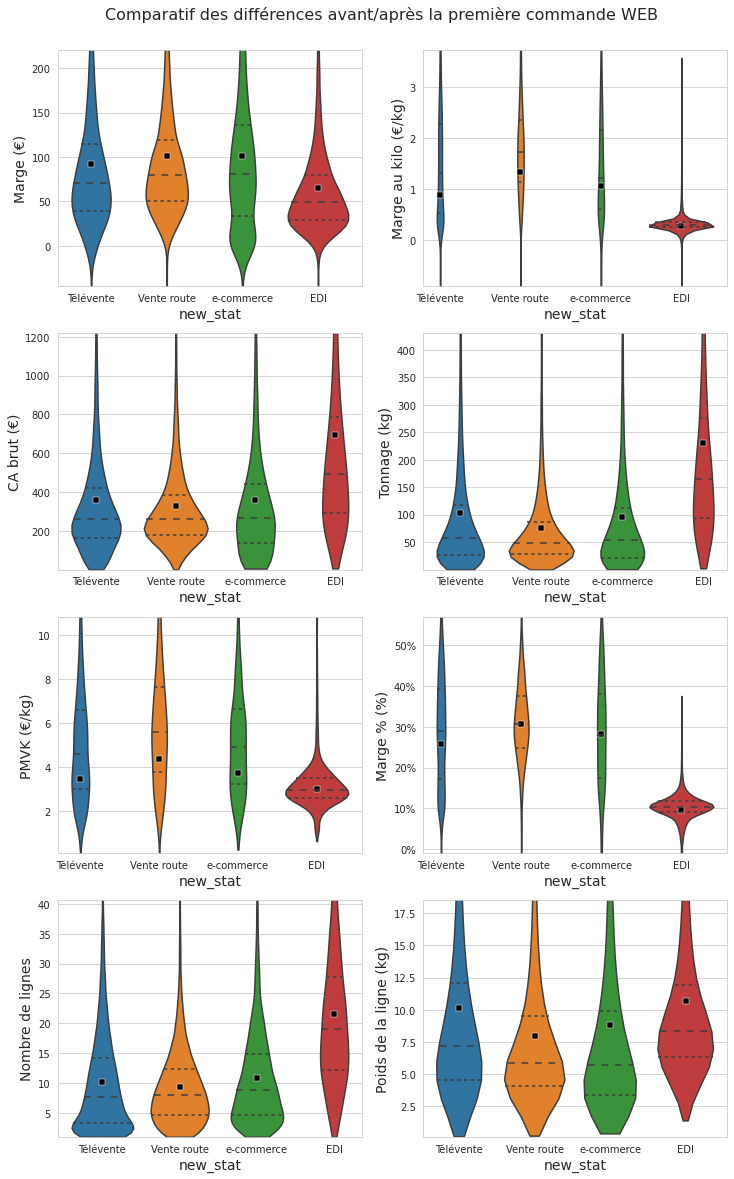

In [113]:
fig, axs = utils.plot_distrib(data=status_updates.reset_index(),
                              indicators=indicators2,
                              filter=None,
                              ncols=2,
                              hue=None,
                              hue_order=None,
                              x='new_stat',
                              order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=.8,
                              show_means=True,
                              plot_kwargs=dict(whis=1.5),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Comparatif des différences avant/après la première commande WEB", fontsize=16, y=.91)

utils.pretty_means(data=status_updates.reset_index(),
                   groupers=['new_stat'],
                   indicators=indicators2,
                   translate=['columns', 'new_stat']
                  )

/homedm/pmasse/WebOrNot/scripts/utils.py:640: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


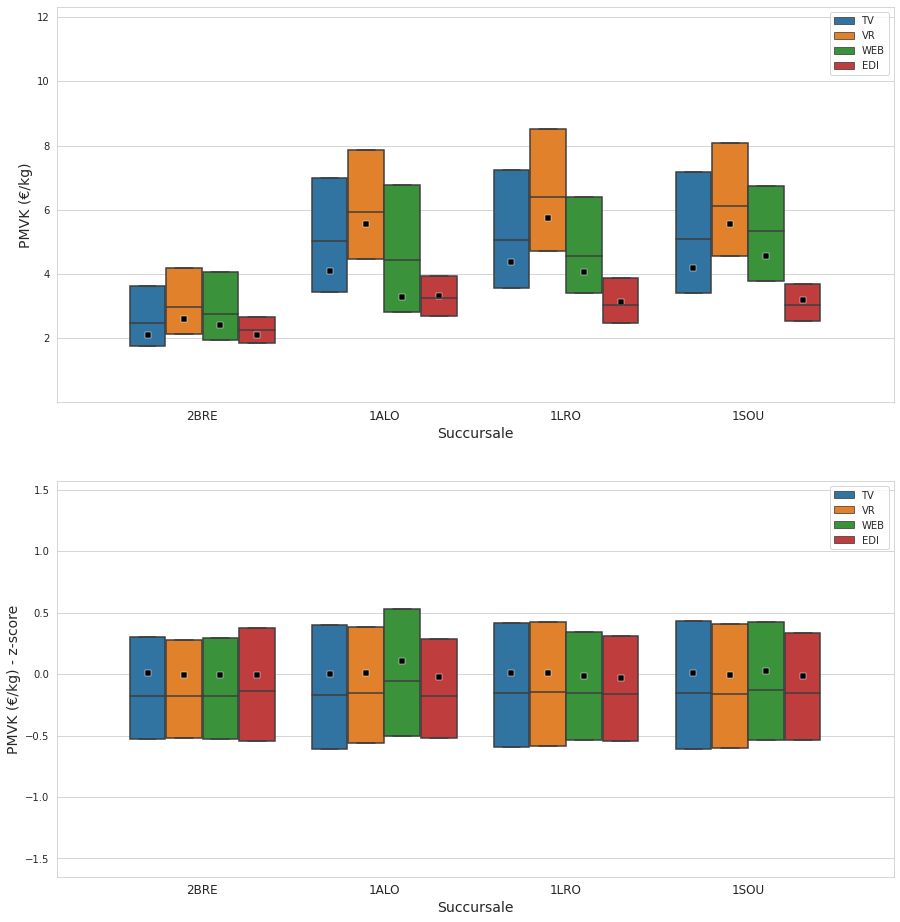

In [114]:
fig, axs = utils.plot_distrib(data=orders,
                              filter=filter_otacos, 
                              indicators=['PMVK', 'PMVK_clt_zscore'],
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              x='orgacom', #'origin2', 
                              order=['2BRE', '1ALO', '1LRO', '1SOU',],
                              kind='boxplot',
                              percentile_selection=.98,
                              IQR_factor_selection=1.5,
                              IQR_factor_plot=1.,
                              show_means=True,
                              translate=['xaxis', 'indicator'],
                             )

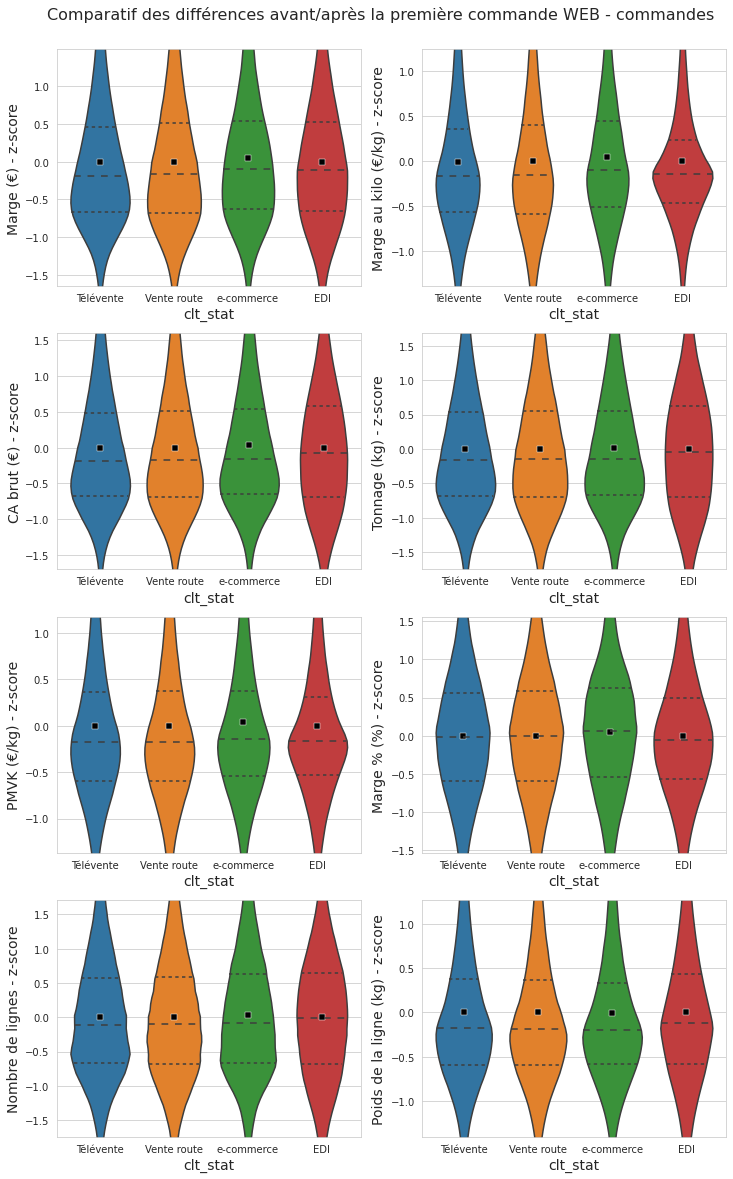

In [115]:
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=None,
                              ncols=2,
                              hue=None,
                              hue_order=None,
                              x='clt_stat',
                              order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=.8,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Comparatif des différences avant/après la première commande WEB - commandes", fontsize=16, y=.91)

utils.pretty_means(data=orders.reset_index(),
                   groupers=['clt_stat'],
                   indicators=indicators2,
                   translate=['columns', 'clt_stat']
                  )

/homedm/pmasse/WebOrNot/scripts/utils.py:640: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


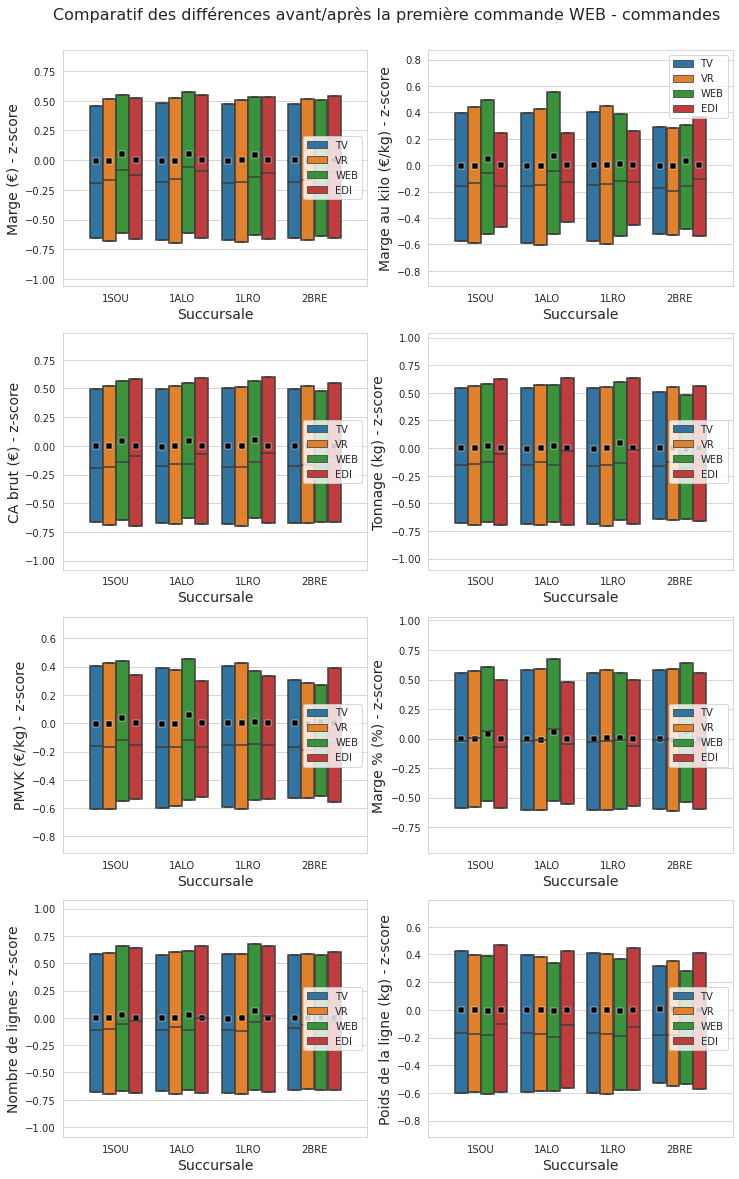

In [116]:
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=None,
                              ncols=2,
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              hue='clt_stat',
                              hue_order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator',],
                              kind='boxplot',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=.3,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Comparatif des différences avant/après la première commande WEB - commandes", fontsize=16, y=.91)

utils.pretty_means(data=orders.reset_index(),
                   groupers=['orgacom', 'clt_stat',],
                   indicators=indicators_zscore,
                   translate=['columns', 'clt_stat']
                  )

## Plot des détails

In [117]:
colors = {'TV': 'blue', 'VR': 'orange', 'WEB': 'green'}
sample_clt = (
# '0000210861'
# '0000020511'
'0000020697'
)
to_plot = orders.loc[idx[:, sample_clt, :]].copy()
to_plot['color'] = to_plot['origin2'].map(colors)
to_plot

margin  brutrevenue   weight  linecount origin2 seg1 seg2  \
orgacom date                                                                    
1ALO    2017-07-05   40.75       277.96   74.280          8      VR   Z3   Z4   
        2017-07-07   21.78       118.19   44.674          5      TV   Z3   Z4   
        2017-07-21   37.21       160.24   71.890          8      VR   Z3   Z4   
        2017-07-28  112.07       458.09   63.622          3      VR   Z3   Z4   
        2017-08-02   59.98       228.31   57.690          7      TV   Z3   Z4   
...                    ...          ...      ...        ...     ...  ...  ...   
        2020-08-10   26.55       122.59   20.400          4      TV   Z3   Z4   
        2020-08-14   95.33       325.25  116.594         15     WEB   Z3   Z4   
        2020-08-21   67.03       294.03   60.499         12      VR   Z3   Z4   
        2020-08-24    9.78        57.08    8.430          6     WEB   Z3   Z4   
        2020-08-28  209.28       712.54  292.463         22     WEB   Z3   Z4   

                   seg3 seg4 cat  ... margin_clt_zscore  \
orgacom date                      ...                     
1ALO    2017-07-05   ZI   ZD  ZP  ...         -0.501258   
        2017-07-07   ZI   ZD  ZP  ...         -0.949642   
        2017-07-21   ZI   ZD  ZP  ...         -0.584931   
        2017-07-28   ZI   ZD  ZP  ...          1.184493   
        2017-08-02   ZI   ZD  ZP  ...         -0.046730   
...                 ...  ...  ..  ...               ...   
        2020-08-10   ZI   ZD  ZP  ...         -0.836896   
        2020-08-14   ZI   ZD  ZP  ...          0.788819   
        2020-08-21   ZI   ZD  ZP  ...          0.119907   
        2020-08-24   ZI   ZD  ZP  ...         -1.233279   
        2020-08-28   ZI   ZD  ZP  ...          3.482192   

                   brutrevenue_clt_zscore PMVK_clt_zscore  \
orgacom date                                                
1ALO    2017-07-05               0.125732       -0.386247   
        2017-07-07              -0.808261       -0.794441   
        2017-07-21              -0.562443       -0.949555   
        2017-07-28               1.178747        0.901171   
        2017-08-02              -0.164515       -0.306029   
...                                   ...             ...   
        2020-08-10              -0.782539        0.457825   
        2020-08-14               0.402183       -0.740837   
        2020-08-21               0.219675        0.029979   
        2020-08-24              -1.165501        0.741412   
        2020-08-28               2.666226       -0.872349   

                   linecount_clt_zscore marginperkg_clt_zscore  \
orgacom date                                                     
1ALO    2017-07-05             0.204194              -0.708051   
        2017-07-07            -0.436232              -0.775405   
        2017-07-21             0.204194              -0.742246   
        2017-07-28            -0.863182               0.629699   
        2017-08-02            -0.009282              -0.166404   
...                                 ...                    ...   
        2020-08-10            -0.649707               0.122318   
        2020-08-14             1.698520              -0.411335   
        2020-08-21             1.058095              -0.091121   
        2020-08-24            -0.222757              -0.033558   
        2020-08-28             3.192847              -0.523885   

                    weight_clt_zscore  marginpercent_clt_zscore  \
orgacom date                                                      
1ALO    2017-07-05           0.297741                 -1.165864   
        2017-07-07          -0.420514                 -0.723291   
        2017-07-21           0.239759                 -0.160209   
        2017-07-28           0.039173                 -0.014171   
        2017-08-02          -0.104740                  0.198057   
...                               ...                       ...   
        2

In [118]:
status_plot = status_updates.loc[idx[: , sample_clt, :]]
status_plot

new_stat     margin  brutrevenue     weight  linecount  \
orgacom date                                                                
1ALO    2017-07-05       VR  58.903706   245.856084  59.780706   6.223776   
        2019-11-29      WEB  72.606341   293.409024  69.773220   9.902439   

                    ordercount      PMVK  marginperkg  marginpercent  \
orgacom date                                                           
1ALO    2017-07-05         143  4.112633     0.985330       0.239586   
        2019-11-29          41  4.205181     1.040605       0.247458   

                    lineweight  margin_clt_zscore  brutrevenue_clt_zscore  \
orgacom date                                                                
1ALO    2017-07-05    9.605215          -0.707107               -0.707107   
        2019-11-29    7.046064           0.707107                0.707107   

                    PMVK_clt_zscore  linecount_clt_zscore  \
orgacom date                                                
1ALO    2017-07-05        -0.707107             -0.707107   
        2019-11-29         0.707107              0.707107   

                    marginperkg_clt_zscore  weight_clt_zscore  \
orgacom date                                                    
1ALO    2017-07-05               -0.707107          -0.707107   
        2019-11-29                0.707107           0.707107   

                    marginpercent_clt_zscore  lineweight_clt_zscore  
orgacom date                                                         
1ALO    2017-07-05                 -0.707107               0.707107  
        2019-11-29                  0.707107              -0.707107

In [119]:
ind_ = 'brutrevenue'

p = figure(x_axis_type="datetime", title='Détail pour ' + sample_clt + " - " + ind_, plot_height=500, plot_width=800)
first_box = BoxAnnotation(left=status_plot.index.get_level_values('date')[0],
#                           bottom=0.,
                          right=status_plot.index.get_level_values('date')[1],
                          fill_color='blue',
                          fill_alpha=.2,
                         )
p.add_layout(first_box)
second_box = BoxAnnotation(left=status_plot.index.get_level_values('date')[1],
#                            bottom=0.,
#                            right=status_plot.index.get_level_values(2)[1],
                           fill_color='green',
                           fill_alpha=.2,
                          )

p.add_layout(second_box)
p.ray(x=datetime.timestamp(status_plot.index.get_level_values('date')[0]) * 1000,
      y=(status_plot[ind_]).iloc[0],
      angle=0.,
      length=(datetime.timestamp(status_plot.index.get_level_values('date')[1]) - datetime.timestamp(status_plot.index.get_level_values('date')[0])) * 1000,
      line_color='blue',
      line_width=2)
p.ray(x=datetime.timestamp(status_plot.index.get_level_values('date')[1]) * 1000,
      y=(status_plot[ind_]).iloc[1],
      angle=0.,
      length=0,
      line_color='green',
      line_width=2)
p.circle(to_plot.index.get_level_values('date'), to_plot[ind_], color=to_plot.color)
show(p)

In [135]:
orders = pd.read_pickle(persist_path / 'small_orders.pkl')
orders

margin  brutrevenue   weight  linecount origin2
orgacom date       client                                                     
1SOU    2017-07-03 0000065940   31.16        84.01    5.501          9      TV
                   0000065945    6.02        23.69    3.734          2      TV
                   0000065975   25.15        97.40   13.718          1      TV
                   0000065998    4.12         8.56    1.000          1      TV
                   0000066014   17.89        48.30    5.000          1      TV
...                               ...          ...      ...        ...     ...
2BRE    2020-08-31 0000285226  103.91       433.56   80.455         24      TV
                   SL001W       89.34       555.25  180.000          4      TV
                   SL0041       28.42      1470.00    7.200          1      TV
                   SL0075       12.76        95.03   15.615         11      TV
                   SL009N       10.51        75.03   40.500          1      TV

[2444326 rows x 5 columns]

In [136]:
to_process = (
orders[['weight', 'margin', 'brutrevenue', 'origin2']].rename_axis('indicators', axis=1)
    .reset_index().astype({'orgacom': 'object', 'origin2': 'object'})
    .set_index(['orgacom', 'client', 'date', 'origin2']).unstack('origin2', fill_value=0)
    .reset_index().set_index('date')
)
to_process

indicators orgacom      client weight                    margin               \
origin2                           EDI       TV   VR  WEB    EDI      TV   VR   
date                                                                           
2017-07-03    1ALO  0000015304    0.0  190.642  0.0  0.0    0.0  202.80  0.0   
2017-07-04    1ALO  0000015304    0.0   24.200  0.0  0.0    0.0   33.70  0.0   
2017-07-05    1ALO  0000015304    0.0  112.550  0.0  0.0    0.0   86.73  0.0   
2017-07-06    1ALO  0000015304    0.0    6.200  0.0  0.0    0.0   17.55  0.0   
2017-07-07    1ALO  0000015304    0.0   27.000  0.0  0.0    0.0   13.77  0.0   
...            ...         ...    ...      ...  ...  ...    ...     ...  ...   
2020-06-23    2BRE      SL009N    0.0  251.844  0.0  0.0    0.0  265.71  0.0   
2020-07-28    2BRE      SL009N    0.0   68.505  0.0  0.0    0.0   25.75  0.0   
2020-08-27    2BRE      SL009N    0.0  103.950  0.0  0.0    0.0   61.10  0.0   
2020-08-31    2BRE      SL009N    0.0   40.500  0.0  0.0    0.0   10.51  0.0   
2018-09-14    2BRE     SLD008B    0.0    4.400  0.0  0.0    0.0    3.82  0.0   

indicators      brutrevenue                     
origin2     WEB         EDI       TV   VR  WEB  
date                                            
2017-07-03  0.0         0.0  1340.95  0.0  0.0  
2017-07-04  0.0         0.0   196.54  0.0  0.0  
2017-07-05  0.0         0.0   916.78  0.0  0.0  
2017-07-06  0.0         0.0    73.36  0.0  0.0  
2017-07-07  0.0         0.0    73.17  0.0  0.0  
...         ...         ...      ...  ...  ...  
2020-06-23  0.0         0.0  1030.32  0.0  0.0  
2020-07-28  0.0         0.0   249.60  0.0  0.0  
2020-08-27  0.0         0.0   629.91  0.0  0.0  
2020-08-31  0.0         0.0    75.03  0.0  0.0  
2018-09-14  0.0         0.0    70.05  0.0  0.0  

[2444326 rows x 14 columns]

**Solution 1**

In [137]:
# %%time
# sol1 = (
# to_process.groupby(['orgacom', 'client'], observed=True, )
#           .apply(lambda x: x.asfreq('B', fill_value=np.nan))
# )
# sol1

**Solution 2**

In [138]:
# %%time
# sol2 = (
# to_process.groupby(['orgacom', 'client'], observed=True, )
#     .apply(lambda x: x.reindex(pd.date_range(x.index.min(), x.index.max(), freq='B'), fill_value=np.nan))
# )
# sol2

**Solution 3**

In [139]:
def create_params(df):
    return (df.reset_index().groupby(['orgacom', 'client'], observed=True, )['date']
            .agg(['min', 'max']).sort_index().reset_index())

def create_multiindex(df, params):
    all_dates = pd.date_range(start='2016-12-31', end='2020-12-31', freq='B')
    midx = (
        (row.orgacom, row.client, d)
        for row in params.itertuples()
        for d in all_dates[(row.min <= all_dates) & (all_dates <= row.max)])
    return pd.MultiIndex.from_tuples(midx, names=['orgacom', 'client', 'date'])

def apply_mulitindex(df, midx):
    return df.set_index(['orgacom', 'client', 'date']).reindex(midx, fill_value=0.)

def new_pipeline(df):
    params = create_params(df)
    midx = create_multiindex(df, params)
    return apply_mulitindex(df, midx)

In [140]:
%%time
day_orders = new_pipeline(to_process.reset_index())
day_orders

CPU times: user 1min 53s, sys: 7.55 s, total: 2min
Wall time: 2min


indicators                    weight                    margin               \
origin2                          EDI       TV   VR  WEB    EDI      TV   VR   
orgacom client     date                                                       
1ALO    0000015304 2017-07-03    0.0  190.642  0.0  0.0    0.0  202.80  0.0   
                   2017-07-04    0.0   24.200  0.0  0.0    0.0   33.70  0.0   
                   2017-07-05    0.0  112.550  0.0  0.0    0.0   86.73  0.0   
                   2017-07-06    0.0    6.200  0.0  0.0    0.0   17.55  0.0   
                   2017-07-07    0.0   27.000  0.0  0.0    0.0   13.77  0.0   
...                              ...      ...  ...  ...    ...     ...  ...   
2BRE    SL009N     2020-08-26    0.0    0.000  0.0  0.0    0.0    0.00  0.0   
                   2020-08-27    0.0  103.950  0.0  0.0    0.0   61.10  0.0   
                   2020-08-28    0.0    0.000  0.0  0.0    0.0    0.00  0.0   
                   2020-08-31    0.0   40.500  0.0  0.0    0.0   10.51  0.0   
        SLD008B    2018-09-14    0.0    4.400  0.0  0.0    0.0    3.82  0.0   

indicators                         brutrevenue                     
origin2                        WEB         EDI       TV   VR  WEB  
orgacom client     date                                            
1ALO    0000015304 2017-07-03  0.0         0.0  1340.95  0.0  0.0  
                   2017-07-04  0.0         0.0   196.54  0.0  0.0  
                   2017-07-05  0.0         0.0   916.78  0.0  0.0  
                   2017-07-06  0.0         0.0    73.36  0.0  0.0  
                   2017-07-07  0.0         0.0    73.17  0.0  0.0  
...                            ...         ...      ...  ...  ...  
2BRE    SL009N     2020-08-26  0.0         0.0     0.00  0.0  0.0  
                   2020-08-27  0.0         0.0   629.91  0.0  0.0  
                   2020-08-28  0.0         0.0     0.00  0.0  0.0  
                   2020-08-31  0.0         0.0    75.03  0.0  0.0  
        SLD008B    2018-09-14  0.0         0.0    70.05  0.0  0.0  

[15650027 rows x 12 columns]

In [132]:
pd.read_pickle(persist_path / 'orders.pkl').index.get_level_values('orgacom').unique()

CategoricalIndex(['1SOU', '1ALO', '1LRO', '2BRE'], categories=['1SOU', '1ALO', '1LRO', '2BRE'], ordered=True, name='orgacom', dtype='category')

**Solution 4**

In [ ]:
# %%time
# sol4 = to_process.groupby(['orgacom', 'client']).resample('B').asfreq()
# sol4

**Solution initiale**

In [ ]:
# %%time
# day_orders = (
# orders[['weight', 'margin', 'brutrevenue', 'origin2']].rename_axis('indicators', axis=1)
#     .reset_index().astype({'orgacom': 'object', 'origin2': 'object'})
#     .set_index(['orgacom', 'client', 'date', 'origin2']).unstack('origin2', fill_value=0)
#     .reset_index().set_index('date')
#     .groupby(['orgacom', 'client'], observed=True, )
#     .apply(lambda x: x.asfreq('B', fill_value=np.nan))
#     .drop(['orgacom', 'client'], axis=1)
#     .fillna(0.)
# #     .unstack('origin2', fill_value=0)
# #     .groupby('indicators', axis=1)
# #     .sum()
# )
# day_orders

In [165]:
day_orders

indicators                    weight                    margin               \
origin2                          EDI       TV   VR  WEB    EDI      TV   VR   
orgacom client     date                                                       
1ALO    0000015304 2017-07-03    0.0  190.642  0.0  0.0    0.0  202.80  0.0   
                   2017-07-04    0.0   24.200  0.0  0.0    0.0   33.70  0.0   
                   2017-07-05    0.0  112.550  0.0  0.0    0.0   86.73  0.0   
                   2017-07-06    0.0    6.200  0.0  0.0    0.0   17.55  0.0   
                   2017-07-07    0.0   27.000  0.0  0.0    0.0   13.77  0.0   
...                              ...      ...  ...  ...    ...     ...  ...   
2BRE    SL009N     2020-08-26    0.0    0.000  0.0  0.0    0.0    0.00  0.0   
                   2020-08-27    0.0  103.950  0.0  0.0    0.0   61.10  0.0   
                   2020-08-28    0.0    0.000  0.0  0.0    0.0    0.00  0.0   
                   2020-08-31    0.0   40.500  0.0  0.0    0.0   10.51  0.0   
        SLD008B    2018-09-14    0.0    4.400  0.0  0.0    0.0    3.82  0.0   

indicators                         brutrevenue                     
origin2                        WEB         EDI       TV   VR  WEB  
orgacom client     date                                            
1ALO    0000015304 2017-07-03  0.0         0.0  1340.95  0.0  0.0  
                   2017-07-04  0.0         0.0   196.54  0.0  0.0  
                   2017-07-05  0.0         0.0   916.78  0.0  0.0  
                   2017-07-06  0.0         0.0    73.36  0.0  0.0  
                   2017-07-07  0.0         0.0    73.17  0.0  0.0  
...                            ...         ...      ...  ...  ...  
2BRE    SL009N     2020-08-26  0.0         0.0     0.00  0.0  0.0  
                   2020-08-27  0.0         0.0   629.91  0.0  0.0  
                   2020-08-28  0.0         0.0     0.00  0.0  0.0  
                   2020-08-31  0.0         0.0    75.03  0.0  0.0  
        SLD008B    2018-09-14  0.0         0.0    70.05  0.0  0.0  

[15650027 rows x 12 columns]

In [141]:
day_orders.to_pickle(persist_path / 'small_day_order.pkl')

<AxesSubplot:xlabel='date'>

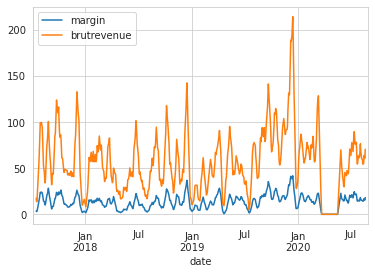

In [164]:
(
    orders
    .reorder_levels([0, 2, 1])
    .sort_index()
    .loc[idx['1ALO', '0000020697'], idx[('margin', 'brutrevenue')]]
    .asfreq('B', fill_value=0)
    .rolling(45, win_type='triang', center=True)
    .mean()
    .plot(kind='line')
)